# Nordeus Data Science Challenge

This document presents a solution to the Nordeus Data Science Challenge from JobFair24, which focuses on predicting user activity after re-registration. Nordeus is a mobile gaming company founded in Serbia, best known for its game Top Eleven — a football management mobile game. The task involves predicting the number of `days_active_first_28_days_after_registration` for users who return to the app after a period of inactivity. Four CSV files are provided: two for training and two for testing. Each pair includes one file with information on users’ previous lives and one file with their most recent registration. The test set lacks the target variable, so we must train the model on the training data and generate predictions for the test users.

Predicting post-registration activity is important for improving user retention strategies and personalize marketing. By identifying patterns in how returning users engage, Nordeus can choose features and interventions that maximize user engagement. Since the test labels are not available, I will split the training data into training and validation sets to evaluate model performance before submiting predictions for test set. This also helps improve generalization, keeping in mind the bias-variance tradeoff.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import random

random.seed(42)
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.INFO)

rd = pd.read_csv('registration_data_training.csv')
pl = pd.read_csv('previous_lives_training_data.csv')
rdx = pd.read_csv('registration_data_test.csv')
plx = pd.read_csv('previous_lives_test_data.csv')

In [3]:
pl['user_id'].value_counts().value_counts()

count
1    26893
2    14388
3     6152
4     2081
5      427
6       56
7        3
Name: count, dtype: int64

It is noticeable that the vast majority of users have only 1 or 2 previous lives, which makes it difficult to extract meaningful sequence trends from such limited data. Therefore, I will proceed with an aggregated approach for feature engineering. For users with 3 or more previous lives, a more advanced model could be introduced in future iterations to predict the days of activity based on temporal patterns. For now I will develop unified model: merging all relevant features into one table and training a single model. As a baseline, I will use a tree-based model, which performs well on tabular data and can handle non-linear relationships effectively.

## Exploratory Data Analysis and Feature Engineering

In [6]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   user_id                                       50000 non-null  int64  
 1   registration_time_utc                         50000 non-null  object 
 2   registration_platform_specific                50000 non-null  object 
 3   registration_country                          50000 non-null  object 
 4   registration_store                            50000 non-null  object 
 5   registration_season_day                       50000 non-null  int64  
 6   registration_channel_detailed                 50000 non-null  object 
 7   registration_device_type                      50000 non-null  object 
 8   registration_device_manufacturer              48187 non-null  object 
 9   session_count                                 50000 non-null 

In [7]:
def rd_fe(rd):
    rd['win_rate'] = np.where(rd['total_match_played_count'] == 0, 0, rd['total_match_won_count'] / rd['total_match_played_count'])
    rd['watch_to_play_ratio'] = np.where(rd['total_match_played_count'] == 0, 0, rd['total_match_watched_count'] / rd['total_match_played_count'])
    rd['session_to_playtime_ratio'] = np.where(rd['session_count'] == 0, 0, rd['playtime'] / rd['session_count'])
    rd['spend_per_session'] = np.where(rd['session_count'] == 0, 0, rd['tokens_spent'] / rd['session_count'])
    rd['iap_per_session'] = np.where(rd['session_count'] == 0, 0, rd['transaction_count_iap'] / rd['session_count'])
    rd['rewarded_video_per_session'] = np.where(rd['session_count'] == 0, 0, rd['transaction_count_rewarded_video'] / rd['session_count'])
    rd['token_net_balance'] = rd['tokens_bought'] + rd['tokens_stash'] - rd['tokens_spent']
    rd['resource_spent_total'] = rd['rests_spent'] + rd['treatments_spent'] + rd['morale_spent']
    rd['star_gap_top_3_vs_11'] = rd['avg_stars_top_3_players'] - rd['avg_stars_top_11_players']
    rd['training_per_session'] = np.where(rd['session_count'] == 0, 0, rd['training_count'] / rd['session_count'])
    rd['session_count_times_training_per_session'] = rd['session_count'] * rd['training_per_session']
    rd['win_rate_times_avg_stars_top_11_players'] = rd['win_rate'] * rd['avg_stars_top_11_players']
    rd['max_possible_days'] = 29 - rd['registration_season_day']
rd_fe(rd)

<Axes: >

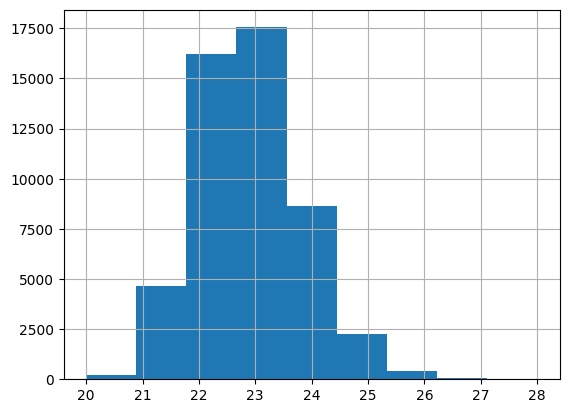

In [8]:
rd['avg_age_top_11_players'].dropna().hist(bins=9)

In [9]:
# handling NaN values
rd['avg_age_top_11_players'].fillna(rd['avg_age_top_11_players'].median(), inplace=True)

C:\Users\Uros\AppData\Local\Temp\ipykernel_216\607107349.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rd['avg_age_top_11_players'].fillna(rd['avg_age_top_11_players'].median(), inplace=True)


In [10]:
rd['registration_device_manufacturer'].value_counts()

registration_device_manufacturer
Apple      12068
samsung    11815
Xiaomi      9685
OPPO        3119
vivo        2298
           ...  
Droi           1
iHunt          1
iBRIT          1
Kalley         1
Samsung        1
Name: count, Length: 165, dtype: int64

I see 'samsung' and 'Samsung'. I wil have to make sure for all cathegorical data to be consistent. When it comes to Nan values, I will write 'UNKNOWN'

In [12]:
def clean_cat_data(df):
    for column in df.select_dtypes(include='object'):
        df[column] = df[column].str.replace(r'\s+', '', regex=True).str.upper() # deletes all spaces and uppers letters

clean_cat_data(rd)
clean_cat_data(pl)
# handling left NaN values
rd['registration_device_manufacturer'] = rd['registration_device_manufacturer'].fillna('UNKNOWN')

Besides possible errors in the labeling of cathegories, In the case of `registration_device_manufacturer` also high cardinality is noticable which might make tree based models overfit, or make training time longer. So I would like to check that.

In [14]:
def cardinality(df):
    # for all object tipes prints number of unique values
    for col in df.select_dtypes(include='object').columns: 
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")

cardinality(rd)
cardinality(pl)

registration_time_utc: 49410 unique values
registration_platform_specific: 7 unique values
registration_country: 184 unique values
registration_store: 7 unique values
registration_channel_detailed: 3 unique values
registration_device_type: 3 unique values
registration_device_manufacturer: 153 unique values
registration_date: 699 unique values
registration_country: 187 unique values
registration_channel_detailed: 3 unique values
registration_store: 6 unique values
registration_platform_specific: 7 unique values


Date/time, location and manufacturer information are critical. From date/time I will take some features that might keep some trends (day of a week, month, year, local hour, for which I will need to use location information and probably some python library or make my own information of local time). This means that information for country needs to be saved for now, but later it will be processed like manufacturer info. 

I will also have to take care that initial categories stay consistent, since choosing category by decardinality might differ in test and train sets. So I will have to lower treshold to 0.5% to lower mistake in case some categories have to merge with 'OTHER' if their category don't match. For now I will just define this function and I will use it later for each model as it is the best to be used.

In [16]:
def decardinality(series, threshold=None):
    # makes all cathegories less then 1% as 'OTHER'
    if threshold is None:
        threshold = series.shape[0] / 100  # default 1% of total
    else:
        threshold = series.shape[0] * threshold / 100 
    
    counts = series.value_counts()
    common = counts[counts > threshold].index
    
    return series.apply(lambda x: x if x in common else 'OTHER')

### Date/Time feature engineering

I am aware of the existence of certain geolocation libraries that can handle time and location operations. However, due to how the data is stored, the algorithmic complexity made these operations time-consuming, and in many cases, the output ended up being NaN or NaT. I also explored available datasets on Kaggle and GitHub, but the ones I found required significant exploration and data cleaning to make them suitable for my needs. Given these challenges, I generated a file using ChatGPT based on available online data. While this approach might have some mistakes, the output seems fine at first glance. The dataset is organized to store the UTC time zone for each country based on the location of its capital, as it's reasonable to assume that most citizens are concentrated there. While I recognize that some countries have multiple time zones, these cases are relatively rare.

In [19]:
tz = pd.read_csv('time_zones.csv')
clean_cat_data(tz)
tz

,Country,Capital,UTC_Offset
0,AFGHANISTAN,KABUL,4.5
1,ALBANIA,TIRANA,1.0
2,ALGERIA,ALGIERS,1.0
3,ANDORRA,ANDORRALAVELLA,1.0
4,ANGOLA,LUANDA,1.0
...,...,...,...
216,ALANDISLANDS,MARIEHAMN,2.0
217,ARUBA,ORANJESTAD,-4.0
218,CAYMANISLANDS,GEORGETOWN,-5.0
219,MAYOTTE,MAMOUDZOU,3.0


In [20]:
# divides variable into two columns
rd['registration_time_utc'] = rd['registration_time_utc'].str[:10] + ' ' + rd['registration_time_utc'].str[10:]
rd['registration_time_utc'] = pd.to_datetime(rd['registration_time_utc'])
rd['registration_date'] = rd['registration_time_utc'].dt.strftime('%d-%m-%Y')
rd['registration_time'] = rd['registration_time_utc'].dt.strftime('%H:%M:%S')
rd.drop(['registration_time_utc'], axis=1, inplace=True)

In [21]:
# transforms registration hours in local time and float type

rd['registration_time'] = pd.to_datetime(rd['registration_time'], format='%H:%M:%S')
rd['registration_time_hours'] = rd['registration_time'].dt.hour + (rd['registration_time'].dt.minute / 60) + (rd['registration_time'].dt.second / 3600)
rd = rd.merge(tz[['Country', 'UTC_Offset']], left_on='registration_country', right_on='Country', how='left')
rd['local_time'] = rd['registration_time_hours'] + rd['UTC_Offset']
rd['local_time'] = rd['local_time'] % 24
rd['local_time'].round().value_counts()
rd.drop(['Country', 'registration_time', 'UTC_Offset', 'registration_time_hours'], axis=1, inplace=True)

When it comes to previous lives data, idea is to percieve majority of tendencies even if learners are weak because that will serve well for tree based models. Later I will decide to terminate some if I notice that some make model harder to learn.

In [23]:
# this cell combines registration date from two tables to make new features

pl['registration_date'] = pd.to_datetime(pl['registration_date'])
history = pl.groupby('user_id')['registration_date'].apply(list).reset_index()
rd_dates = rd[['user_id', 'registration_date']]
combined = pd.merge(rd_dates, history, on='user_id', how='left')
def add_current_to_history(row):
    previous = row['registration_date_y'] if isinstance(row['registration_date_y'], list) else []
    return previous + [row['registration_date_x']]

combined['full_registration_history'] = combined.apply(add_current_to_history, axis=1)

combined = combined[['user_id', 'full_registration_history']]

In [24]:
combined

,user_id,full_registration_history
0,5,"[2022-04-21 00:00:00, 2023-05-07 00:00:00, 25-..."
1,7,"[2022-04-06 00:00:00, 2023-02-06 00:00:00, 202..."
2,13,"[2022-10-18 00:00:00, 2023-08-17 00:00:00, 31-..."
3,23,"[2023-08-30 00:00:00, 31-05-2024]"
4,25,"[2022-08-24 00:00:00, 2023-08-15 00:00:00, 15-..."
...,...,...
49995,218943,"[2022-08-30 00:00:00, 2022-12-19 00:00:00, 202..."
49996,218947,"[2022-05-30 00:00:00, 2023-01-20 00:00:00, 202..."
49997,218948,"[2023-11-10 00:00:00, 04-06-2024]"
49998,218949,"[2022-10-15 00:00:00, 27-05-2024]"


In [25]:
from scipy.stats import mode

# creation of the new aggregated dataframe based on previous lives

agg_pl = pl.groupby('user_id').agg({
    # sum of all transactions
    'transaction_count_iap_lifetime': 'sum', 
    # if user was ever a payer or watcher
    'is_payer_lifetime': 'max',
    'is_rewarded_video_watcher_lifetime': 'max',
    # most frequent country, channel, store, platform from user in history
    'registration_country': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_channel_detailed': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_store': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_platform_specific': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    # avg first registration day
    'registration_season_day': 'mean',
}).reset_index()

life_stats = pl.groupby('user_id')['days_active_lifetime'].agg(
    # from data about days active this should give a light insight in user behaviour
    std_days_active='std',
    mean_days_active= 'mean',
    no_prev_lives= 'count'
).reset_index()

life_stats['std_days_active'] = life_stats['std_days_active'].fillna(0)

agg_pl = agg_pl.merge(life_stats, on='user_id', how='left')



In [26]:
# rename the newly created columns to desired names
agg_pl = agg_pl.rename(columns={
    'registration_country': 'pl_registration_country',
    'registration_channel_detailed': 'pl_registration_channel_detailed',
    'registration_store': 'pl_registration_store',
    'registration_platform_specific': 'pl_registration_platform_specific',
    'registration_season_day': 'mean_registration_season_day'
})

In [27]:
if rd['user_id'].sort_values().reset_index(drop=True).equals(agg_pl['user_id'].sort_values().reset_index(drop=True)):
    print('All user_id match')
else:
    print('There is mismatch between user_ids')

All user_id match


In [28]:
# this cell takes insights from combined about overall behaviour of a user
from datetime import datetime

def time_features(row):
    dates = row['full_registration_history']
    
    # convert to datetime.date
    parsed_dates = []
    for d in dates:
        if isinstance(d, str):
            d = datetime.strptime(d, "%d-%m-%Y")
        elif isinstance(d, pd.Timestamp):
            d = d.to_pydatetime()
        parsed_dates.append(d)

    parsed_dates.sort()

    # day differences
    diffs = [(parsed_dates[i+1] - parsed_dates[i]).days for i in range(len(parsed_dates) - 1)]

    # features
    avg_days = np.mean(diffs)
    std_days = np.std(diffs) if len(diffs) > 1 else 0
    last_two_diff = diffs[-1]

    return pd.Series({
        'avg_days_between_registrations': avg_days,
        'std_days_between_registrations': std_days,
        'days_between_last_two': last_two_diff
    })

features = combined.apply(time_features, axis=1)

final = pd.concat([combined[['user_id']], features], axis=1)

# merging final insights to agg_pl
agg_pl = pd.merge(agg_pl, final, on='user_id', how='left')

In [29]:
from scipy.stats import entropy
def safe_entropy(series):
    counts = series.value_counts()
    if len(counts) <= 1:
        return 0.0
    return entropy(counts)

entropy_variance_stats = pl.groupby('user_id').agg({
    'registration_country': safe_entropy,
    'registration_channel_detailed': safe_entropy,
    'registration_store': safe_entropy,
    'registration_platform_specific': safe_entropy,
    'registration_season_day': 'var',
    'days_active_lifetime': 'var',
    'transaction_count_iap_lifetime': 'var',
}).reset_index().rename(columns={
    'registration_country': 'entropy_country',
    'registration_channel_detailed': 'entropy_channel',
    'registration_store': 'entropy_store',
    'registration_platform_specific': 'entropy_platform',
    'registration_season_day': 'var_registration_season_day',
    'days_active_lifetime': 'var_days_active_lifetime',
    'transaction_count_iap_lifetime': 'var_transaction_count',
})

In [30]:
for col in ['var_registration_season_day', 'var_days_active_lifetime', 'var_transaction_count']:
    entropy_variance_stats[col] = entropy_variance_stats[col].fillna(0)

agg_pl = agg_pl.merge(entropy_variance_stats, on='user_id', how='left')

In [31]:
unique_counts = pl.groupby('user_id').agg({
    'registration_country': lambda x: x.nunique(),
    'registration_store': lambda x: x.nunique()
}).reset_index().rename(columns={
    'registration_country': 'unique_country_count',
    'registration_store': 'unique_store_count'
})

agg_pl = agg_pl.merge(unique_counts, on='user_id', how='left')

Initial idea was to have month year and weekday. Since year is only 2024 in rd and rdx and since only May and June are the data in rd and June and July in rdx, I will keep just weekdays as only trend that might give more insights.

In [33]:
rd['registration_date'] = pd.to_datetime(rd['registration_date'])
rd['registration_weekday'] = rd['registration_date'].dt.day_name()

C:\Users\Uros\AppData\Local\Temp\ipykernel_216\778266404.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  rd['registration_date'] = pd.to_datetime(rd['registration_date'])


In [34]:
rd.drop(['registration_date'], inplace=True, axis=1)

In [35]:
um = rd.merge(agg_pl, on='user_id', how='left')
um.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 67 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   user_id                                       50000 non-null  int64  
 1   registration_platform_specific                50000 non-null  object 
 2   registration_country                          50000 non-null  object 
 3   registration_store                            50000 non-null  object 
 4   registration_season_day                       50000 non-null  int64  
 5   registration_channel_detailed                 50000 non-null  object 
 6   registration_device_type                      50000 non-null  object 
 7   registration_device_manufacturer              50000 non-null  object 
 8   session_count                                 50000 non-null  int64  
 9   playtime                                      50000 non-null 

In [36]:
cardinality(um)

registration_platform_specific: 7 unique values
registration_country: 184 unique values
registration_store: 7 unique values
registration_channel_detailed: 3 unique values
registration_device_type: 3 unique values
registration_device_manufacturer: 153 unique values
registration_weekday: 7 unique values
pl_registration_country: 181 unique values
pl_registration_channel_detailed: 4 unique values
pl_registration_store: 7 unique values
pl_registration_platform_specific: 8 unique values


In [37]:
um['registration_country'] = decardinality(um['registration_country'], 0.5)
um['pl_registration_country'] = decardinality(um['pl_registration_country'], 0.5)
um['registration_device_manufacturer'] = decardinality(um['registration_device_manufacturer'], 0.5)

In [38]:
# these variables need to store common countries and manufacturers because the other dataset might not be the same
common_countries = np.unique(um['registration_country'].values)
common_pl_countries = np.unique(um['pl_registration_country'].values)
common_manufacturer = np.unique(um['registration_device_manufacturer'].values)

Also I will have to possibly drop some of the features due to the higher correlation. Here is the function:

In [40]:
from sklearn.preprocessing import LabelEncoder

def drop_highly_correlated_features(df, target, high_thresh=0.9, plot=True):

    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in cat_cols:
        df_encoded[col] = le.fit_transform(df_encoded[col])

    corr_matrix = df_encoded.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()

    for col in upper.columns:
        for row in upper.index:
            corr_value = upper.loc[row, col]
            if pd.notnull(corr_value) and corr_value > high_thresh:
                # drop the one with lower absolute correlation to target
                if abs(corr_matrix.loc[row, target]) >= abs(corr_matrix.loc[col, target]):
                    to_drop.add(col)
                else:
                    to_drop.add(row)

    df_cleaned = df.drop(columns=list(to_drop))

    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
        plt.title("Correlation Matrix Before Dropping")
        plt.show()

    return df_cleaned, list(to_drop)

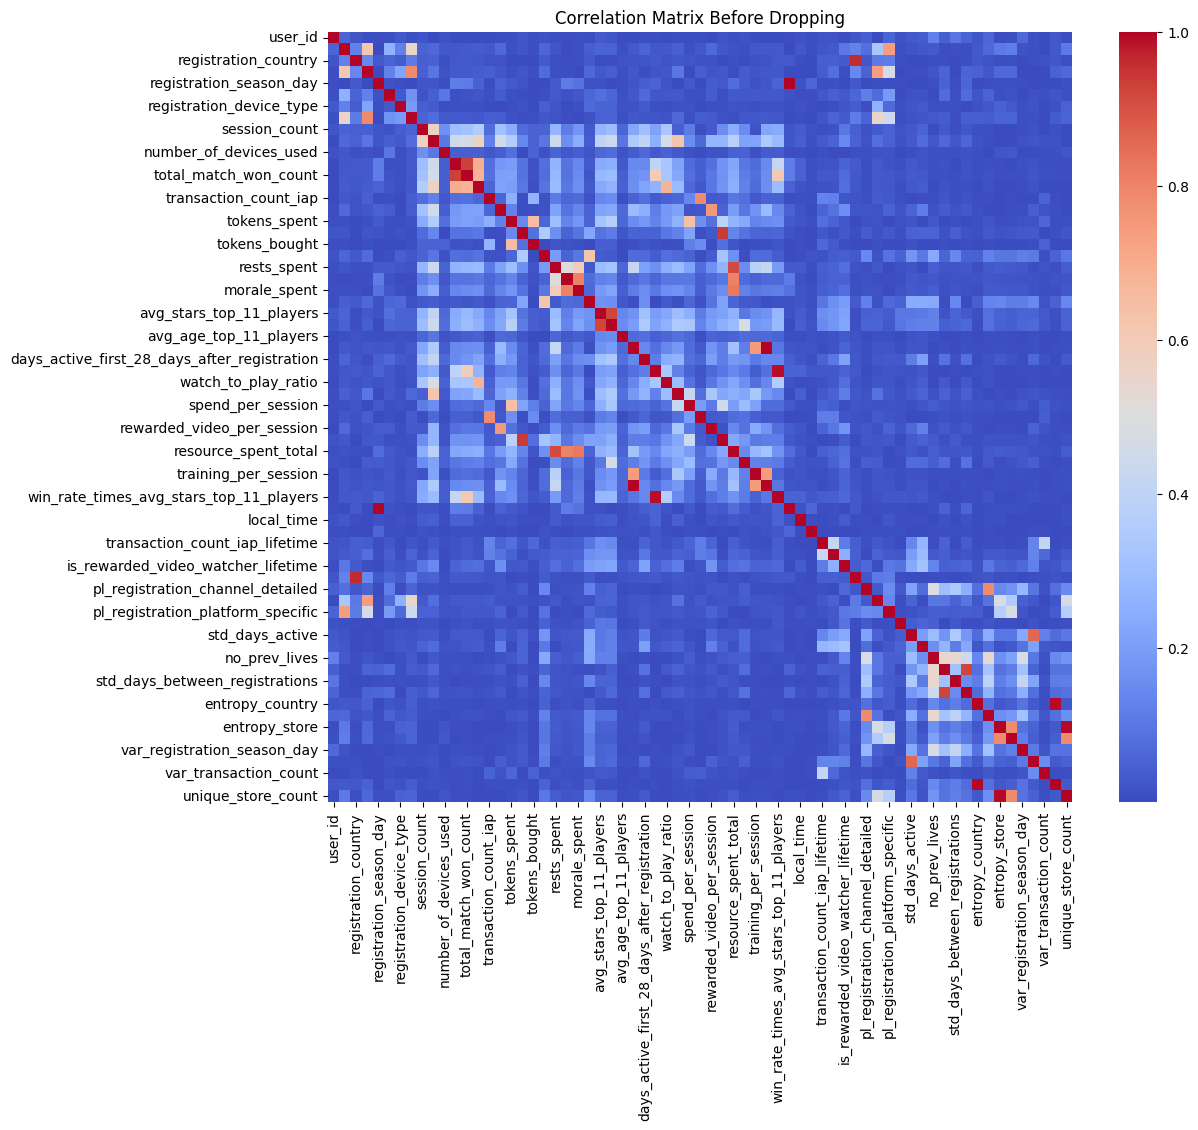

Dropped columns: ['total_match_played_count', 'max_possible_days', 'win_rate', 'resource_spent_total', 'session_count_times_training_per_session', 'days_between_last_two', 'unique_store_count', 'avg_stars_top_11_players', 'entropy_country', 'registration_country', 'tokens_stash']


In [41]:
clean_um, dropped_cols1 = drop_highly_correlated_features(um, 'days_active_first_28_days_after_registration')
print("Dropped columns:", dropped_cols1)

Tree based models are normally fine with skews. But most of the vars turned to be extremly skewed so after using this method, MAE dropped for 5

In [43]:
from scipy.stats import skew, boxcox, yeojohnson

def transform_skewed_features(X, target_column=None, skew_thresh=0.75):
    X_transformed = X.copy()
    numeric_cols = X.select_dtypes(include=np.number).columns.drop(target_column, errors='ignore')
    
    skew_stats = []
    transformations = {}

    for col in numeric_cols:
        original_skew = skew(X[col])
        
        if abs(original_skew) > skew_thresh:
            if (X[col] <= 0).any():
                transformed, _ = yeojohnson(X[col])
                X_transformed[col] = transformed
                method = 'yeojohnson'
            else:
                transformed, _ = boxcox(X[col])
                X_transformed[col] = transformed
                method = 'boxcox'

            new_skew = skew(X_transformed[col])
            transformations[col] = method
        else:
            new_skew = original_skew
            method = 'none'
        
        skew_stats.append({
            'feature': col,
            'original_skew': original_skew,
            'new_skew': new_skew,
            'transformation': method
        })

    skew_stats_df = pd.DataFrame(skew_stats).set_index('feature')
    return X_transformed, skew_stats_df, transformations

In [44]:
um_transform, skew_report, applied_transforms = transform_skewed_features(clean_um, target_column='days_active_first_28_days_after_registration')
print(skew_report)

                                         original_skew   new_skew  \
feature                                                             
user_id                                      -0.006624  -0.006624   
registration_season_day                       0.136840   0.136840   
session_count                                 3.836181   0.059790   
playtime                                      3.589065  -0.032164   
number_of_devices_used                        3.345927   1.258441   
total_match_won_count                         3.546574   0.384161   
total_match_watched_count                     4.958470   1.393678   
transaction_count_iap                        22.599372   9.332809   
transaction_count_rewarded_video              6.918627   0.894915   
tokens_spent                                 52.979983   0.020586   
tokens_bought                               167.043327  12.793463   
rests_stash                                   1.599141   0.097619   
rests_spent                       

In [45]:
from scipy.stats.mstats import winsorize

def winsorize_and_update_skew(X, skew_report, skew_threshold=1.0, limits=(0.01, 0.01)):
    X_winsorized = X.copy()
    updated_skew_report = skew_report.copy()

    high_skew_features = skew_report[skew_report['new_skew'].abs() > skew_threshold].index.tolist()

    for col in high_skew_features:
        if col in X_winsorized.columns:
            X_winsorized[col] = winsorize(X_winsorized[col], limits=limits)
            print(col)

            if np.isclose(np.var(X_winsorized[col]), 0):
                new_skew_value = 0.0
                print(f"{col} variance near zero — set skew to 0")
            else:
                new_skew_value = skew(X_winsorized[col])

            updated_skew_report.loc[col, 'post_winsor_skew'] = new_skew_value

    return X_winsorized, updated_skew_report


In [46]:
X_winsorized, updated_skew_report = winsorize_and_update_skew(um_transform, skew_report)

number_of_devices_used
number_of_devices_used variance near zero — set skew to 0
total_match_watched_count
transaction_count_iap
tokens_bought
tokens_bought variance near zero — set skew to 0
treatments_spent
watch_to_play_ratio
iap_per_session
token_net_balance
transaction_count_iap_lifetime
entropy_channel
entropy_store
entropy_platform
var_transaction_count
unique_country_count


In [47]:
common_columns = X_winsorized.columns.intersection(um_transform.columns)
um_transform[common_columns] = X_winsorized[common_columns]
common_columns = um_transform.columns.intersection(clean_um.columns)
clean_um[common_columns] = um_transform[common_columns]

In [48]:
# low variance
numeric_cols = clean_um.select_dtypes(include=[np.number])
low_variance_features = numeric_cols.var()[numeric_cols.var() < 1e-5].index.tolist()

print(f"Dropping low-variance features: {low_variance_features}")
X_cleaned = clean_um.drop(columns=low_variance_features)

Dropping low-variance features: ['number_of_devices_used', 'transaction_count_iap', 'tokens_bought', 'iap_per_session', 'entropy_store', 'unique_country_count']


In [49]:
X_cleaned.to_csv('X_cleaned.csv', index=False)

In [50]:
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   user_id                                       50000 non-null  int64  
 1   registration_platform_specific                50000 non-null  object 
 2   registration_store                            50000 non-null  object 
 3   registration_season_day                       50000 non-null  int64  
 4   registration_channel_detailed                 50000 non-null  object 
 5   registration_device_type                      50000 non-null  object 
 6   registration_device_manufacturer              50000 non-null  object 
 7   session_count                                 50000 non-null  float64
 8   playtime                                      50000 non-null  float64
 9   total_match_won_count                         50000 non-null 

Interesting fact: some of the variables dropped in some of the previous tests were shown to have low learning importnce.

## Terst data

In [53]:
# handling NaN values
rdx['avg_age_top_11_players'].fillna(rdx['avg_age_top_11_players'].median(), inplace=True)
rd_fe(rdx)

clean_cat_data(rdx)
clean_cat_data(plx)

# handling left NaN values
rdx['registration_device_manufacturer'] = rdx['registration_device_manufacturer'].fillna('UNKNOWN')

# divides variable into two columns
rdx['registration_time_utc'] = rdx['registration_time_utc'].str[:10] + ' ' + rdx['registration_time_utc'].str[10:]
rdx['registration_time_utc'] = pd.to_datetime(rdx['registration_time_utc'])
rdx['registration_date'] = rdx['registration_time_utc'].dt.strftime('%d-%m-%Y')
rdx['registration_time'] = rdx['registration_time_utc'].dt.strftime('%H:%M:%S')
rdx.drop(['registration_time_utc'], axis=1, inplace=True)

# transforms registration hours in local time and float type
rdx['registration_time'] = pd.to_datetime(rdx['registration_time'], format='%H:%M:%S')
rdx['registration_time_hours'] = rdx['registration_time'].dt.hour + (rdx['registration_time'].dt.minute / 60) + (rdx['registration_time'].dt.second / 3600)
rdx = rdx.merge(tz[['Country', 'UTC_Offset']], left_on='registration_country', right_on='Country', how='left')
rdx['local_time'] = rdx['registration_time_hours'] + rdx['UTC_Offset']
rdx['local_time'] = rdx['local_time'] % 24
rdx.drop(['Country', 'registration_time', 'UTC_Offset', 'registration_time_hours'], axis=1, inplace=True)

# this cell combines registration date from two tables to make new features
plx['registration_date'] = pd.to_datetime(plx['registration_date'])
history = plx.groupby('user_id')['registration_date'].apply(list).reset_index()
rdx_dates = rdx[['user_id', 'registration_date']]
combined = pd.merge(rdx_dates, history, on='user_id', how='left')
def add_current_to_history(row):
    previous = row['registration_date_y'] if isinstance(row['registration_date_y'], list) else []
    return previous + [row['registration_date_x']]

combined['full_registration_history'] = combined.apply(add_current_to_history, axis=1)
combined = combined[['user_id', 'full_registration_history']]

# creation of the new aggregated dataframe based on previous lives

agg_plx = plx.groupby('user_id').agg({
    # sum of all transactions
    'transaction_count_iap_lifetime': 'sum', 
    # if user was ever a payer or watcher
    'is_payer_lifetime': 'max',
    'is_rewarded_video_watcher_lifetime': 'max',
    # most frequent country, channel, store, platform from user in history
    'registration_country': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_channel_detailed': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_store': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    'registration_platform_specific': lambda x: x.iloc[0] if x.nunique() == 1 else 'MULTIPLE',
    # avg first registration day
    'registration_season_day': 'mean',
}).reset_index()

life_stats = plx.groupby('user_id')['days_active_lifetime'].agg(
    # from data about days active this should give a light insight in user behaviour
    std_days_active='std',
    mean_days_active= 'mean',
    no_prev_lives= 'count'
).reset_index()

life_stats['std_days_active'] = life_stats['std_days_active'].fillna(0)

agg_plx = agg_plx.merge(life_stats, on='user_id', how='left')

# rename the newly created columns to desired names
agg_plx = agg_plx.rename(columns={
    'registration_country': 'pl_registration_country',
    'registration_channel_detailed': 'pl_registration_channel_detailed',
    'registration_store': 'pl_registration_store',
    'registration_platform_specific': 'pl_registration_platform_specific',
    'registration_season_day': 'mean_registration_season_day'
})

if rdx['user_id'].sort_values().reset_index(drop=True).equals(agg_plx['user_id'].sort_values().reset_index(drop=True)):
    print('All user_id match')
else:
    print('There is mismatch between user_ids')

C:\Users\Uros\AppData\Local\Temp\ipykernel_216\3736772482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rdx['avg_age_top_11_players'].fillna(rdx['avg_age_top_11_players'].median(), inplace=True)


All user_id match


In [54]:
# this cell takes insights from combined about overall behaviour of a user
features = combined.apply(time_features, axis=1)
final = pd.concat([combined[['user_id']], features], axis=1)

# merging final insights to agg_pl
agg_plx = pd.merge(agg_plx, final, on='user_id', how='left')

entropy_variance_stats = plx.groupby('user_id').agg({
    'registration_country': safe_entropy,
    'registration_channel_detailed': safe_entropy,
    'registration_store': safe_entropy,
    'registration_platform_specific': safe_entropy,
    'registration_season_day': 'var',
    'days_active_lifetime': 'var',
    'transaction_count_iap_lifetime': 'var',
}).reset_index().rename(columns={
    'registration_country': 'entropy_country',
    'registration_channel_detailed': 'entropy_channel',
    'registration_store': 'entropy_store',
    'registration_platform_specific': 'entropy_platform',
    'registration_season_day': 'var_registration_season_day',
    'days_active_lifetime': 'var_days_active_lifetime',
    'transaction_count_iap_lifetime': 'var_transaction_count',
})

for col in ['var_registration_season_day', 'var_days_active_lifetime', 'var_transaction_count']:
    entropy_variance_stats[col] = entropy_variance_stats[col].fillna(0)

agg_plx = agg_plx.merge(entropy_variance_stats, on='user_id', how='left')

unique_counts = plx.groupby('user_id').agg({
    'registration_country': lambda x: x.nunique(),
    'registration_store': lambda x: x.nunique()
}).reset_index().rename(columns={
    'registration_country': 'unique_country_count',
    'registration_store': 'unique_store_count'
})

agg_plx = agg_plx.merge(unique_counts, on='user_id', how='left')

rdx['registration_date'] = pd.to_datetime(rdx['registration_date'], format='%d-%m-%Y')
rdx['registration_weekday'] = rdx['registration_date'].dt.day_name()

rdx.drop(['registration_date'], inplace=True, axis=1)
umx = rdx.merge(agg_plx, on='user_id', how='left')

In [55]:
cardinality(umx)

registration_platform_specific: 7 unique values
registration_country: 187 unique values
registration_store: 7 unique values
registration_channel_detailed: 3 unique values
registration_device_type: 3 unique values
registration_device_manufacturer: 154 unique values
registration_weekday: 7 unique values
pl_registration_country: 189 unique values
pl_registration_channel_detailed: 4 unique values
pl_registration_store: 7 unique values
pl_registration_platform_specific: 8 unique values


In [56]:
def apply_train_cardinality(df, col_name, common_values):
    df[col_name] = df[col_name].where(df[col_name].isin(common_values), 'OTHER')
    return df

umx = apply_train_cardinality(umx, 'registration_country', common_countries)
umx = apply_train_cardinality(umx, 'pl_registration_country', common_pl_countries)
umx = apply_train_cardinality(umx, 'registration_device_manufacturer', common_manufacturer)

In [57]:
um['registration_country'].value_counts()

registration_country
INDONESIA        12018
OTHER             7349
TURKEY            4472
BRAZIL            3067
GERMANY           2130
UNITEDKINGDOM     1700
FRANCE            1619
THAILAND          1544
ITALY             1339
SPAIN             1236
MALAYSIA          1162
POLAND            1160
UNITEDSTATES       951
ARGENTINA          852
GREECE             745
EGYPT              728
ROMANIA            680
ISRAEL             651
PORTUGAL           590
MEXICO             566
CZECHREPUBLIC      559
INDIA              533
SERBIA             445
SAUDIARABIA        437
COLOMBIA           395
NETHERLANDS        392
BELGIUM            376
NIGERIA            363
AUSTRIA            359
CHILE              353
VIETNAM            342
MOROCCO            332
SWEDEN             286
SOUTHAFRICA        269
Name: count, dtype: int64

In [58]:
# I will use same features to drop as it was dropped in test
umx.drop(dropped_cols1, inplace=True, axis=1)

In [59]:

umx_transform, skew_report, applied_transforms = transform_skewed_features(umx)
print(skew_report)

X_winsorizedx, updated_skew_report = winsorize_and_update_skew(umx_transform, skew_report)

common_columns = X_winsorizedx.columns.intersection(umx_transform.columns)
umx_transform[common_columns] = X_winsorizedx[common_columns]
common_columns = umx_transform.columns.intersection(umx.columns)
umx[common_columns] = umx_transform[common_columns]

# low variance
numeric_cols = umx.select_dtypes(include=[np.number])
low_variance_features = numeric_cols.var()[numeric_cols.var() < 1e-5].index.tolist()

print(f"Dropping low-variance features: {low_variance_features}")
X_cleanedx = umx.drop(columns=low_variance_features)

                                         original_skew   new_skew  \
feature                                                             
user_id                                      -0.008307  -0.008307   
registration_season_day                       0.093620   0.093620   
session_count                                 3.675338   0.035873   
playtime                                      3.554282  -0.030526   
number_of_devices_used                        2.511612   1.480952   
total_match_won_count                         4.817627   0.349343   
total_match_watched_count                     4.789186   1.001248   
transaction_count_iap                        16.782595   8.963564   
transaction_count_rewarded_video              7.346262   0.998305   
tokens_spent                                 43.753176   0.061300   
tokens_bought                               104.895730  13.274678   
rests_stash                                   1.653874  -0.640662   
rests_spent                       

In [60]:
umx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  50000 non-null  int64  
 1   registration_platform_specific           50000 non-null  object 
 2   registration_store                       50000 non-null  object 
 3   registration_season_day                  50000 non-null  int64  
 4   registration_channel_detailed            50000 non-null  object 
 5   registration_device_type                 50000 non-null  object 
 6   registration_device_manufacturer         50000 non-null  object 
 7   session_count                            50000 non-null  float64
 8   playtime                                 50000 non-null  float64
 9   number_of_devices_used                   50000 non-null  float64
 10  total_match_won_count                    50000

# Train and test

In [62]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder

X = X_cleaned.drop(columns=['days_active_first_28_days_after_registration', 'user_id'])
y = np.log1p(X_cleaned['days_active_first_28_days_after_registration']) # getting better results for skewness

X_encoded = X.copy()
cat_features = X.select_dtypes(include='object').columns
for col in cat_features:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [63]:
def le_to_ae(y, f):  # y: observed (log1p), f: predicted (log1p)
    LE1p = f - y  # log(f+1) - log(y+1)
    ae = np.abs((np.expm1(y) + 1) * (np.expm1(LE1p)))
    return ae

def mae_calculator(model, trial=None):
    aes = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_log1p = model.predict(X_test_fold)

        ae = le_to_ae(y_test_fold, y_pred_log1p)
        aes.extend(ae)

    mae = np.mean(aes)

    if trial:
        print(f"XGBoost Trial {trial.number} MAE (Original Scale): {mae:.4f}")
    else:
        print(f"MAE (Original Scale): {mae:.4f}")

    return mae



def objective_xgb(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 0.5, 3.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.5, 3.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 200)

    xgb_model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        n_estimators=n_estimators,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0,
    )

    return mae_calculator(xgb_model, trial)
    

def objective_lgb(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    num_leaves = trial.suggest_int('num_leaves', 20, 60)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 0.5, 3.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.5, 3.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 200)

    lgb_model = lgb.LGBMRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        n_estimators=n_estimators,
        random_state=42,
        objective='regression',
        verbose=-1,
    )
    
    return mae_calculator(lgb_model, trial)

def objective_cat(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 4, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.5, 3.0)
    iterations = trial.suggest_int('iterations', 100, 200)

    cat_model = cb.CatBoostRegressor(
        loss_function='MAE',
        learning_rate=learning_rate,
        depth=depth,
        subsample=subsample,
        colsample_bylevel=colsample_bylevel,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        random_seed=42,
        verbose=0
    )
    
    return mae_calculator(cat_model, trial)

In [64]:
study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50)
print("Best hyperparameters for XGBoost: ", study_xgb.best_params)

[I 2025-04-30 00:26:08,528] A new study created in memory with name: no-name-2edb832c-2847-4876-be61-ffd0f9f09204
[I 2025-04-30 00:26:39,637] Trial 0 finished with value: 5.567821339448658 and parameters: {'learning_rate': 0.11861663446573512, 'max_depth': 10, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'lambda_l1': 0.8900466011060912, 'lambda_l2': 0.8899863008405067, 'n_estimators': 105}. Best is trial 0 with value: 5.567821339448658.


XGBoost Trial 0 MAE (Original Scale): 5.5678


[I 2025-04-30 00:26:48,788] Trial 1 finished with value: 5.643620405983753 and parameters: {'learning_rate': 0.2611910822747312, 'max_depth': 7, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'lambda_l1': 2.9247746304049858, 'lambda_l2': 2.5811066020010545, 'n_estimators': 121}. Best is trial 0 with value: 5.567821339448658.


XGBoost Trial 1 MAE (Original Scale): 5.6436


[I 2025-04-30 00:26:54,275] Trial 2 finished with value: 5.509954613204553 and parameters: {'learning_rate': 0.06272924049005918, 'max_depth': 4, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'lambda_l1': 1.5798625466052894, 'lambda_l2': 1.2280728504951048, 'n_estimators': 161}. Best is trial 2 with value: 5.509954613204553.


XGBoost Trial 2 MAE (Original Scale): 5.5100


[I 2025-04-30 00:27:00,360] Trial 3 finished with value: 5.509685312038206 and parameters: {'learning_rate': 0.05045321958909213, 'max_depth': 5, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'lambda_l1': 2.462939903482534, 'lambda_l2': 0.9991844553958993, 'n_estimators': 151}. Best is trial 3 with value: 5.509685312038206.


XGBoost Trial 3 MAE (Original Scale): 5.5097


[I 2025-04-30 00:27:05,367] Trial 4 finished with value: 5.487164462476625 and parameters: {'learning_rate': 0.18180022496999232, 'max_depth': 3, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'lambda_l1': 0.6626289824631988, 'lambda_l2': 2.8722138431333333, 'n_estimators': 197}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 4 MAE (Original Scale): 5.4872


[I 2025-04-30 00:27:13,444] Trial 5 finished with value: 5.582305541963238 and parameters: {'learning_rate': 0.24443523095377373, 'max_depth': 5, 'subsample': 0.6390688456025535, 'colsample_bytree': 0.8736932106048627, 'lambda_l1': 1.6003812343490034, 'lambda_l2': 0.8050955871119471, 'n_estimators': 150}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 5 MAE (Original Scale): 5.5823


[I 2025-04-30 00:28:04,805] Trial 6 finished with value: 5.588541017496323 and parameters: {'learning_rate': 0.019972671123413333, 'max_depth': 10, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'lambda_l1': 1.2792776902235274, 'lambda_l2': 1.800170052944527, 'n_estimators': 155}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 6 MAE (Original Scale): 5.5885


[I 2025-04-30 00:29:04,219] Trial 7 finished with value: 5.5361066191770645 and parameters: {'learning_rate': 0.06360779210240283, 'max_depth': 10, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'lambda_l1': 2.737068376069122, 'lambda_l2': 1.9947499470277128, 'n_estimators': 193}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 7 MAE (Original Scale): 5.5361


[I 2025-04-30 00:29:10,009] Trial 8 finished with value: 5.539202197324225 and parameters: {'learning_rate': 0.03566282559505665, 'max_depth': 4, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'lambda_l1': 1.471693224223705, 'lambda_l2': 1.1783725794347397, 'n_estimators': 183}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 8 MAE (Original Scale): 5.5392


[I 2025-04-30 00:29:17,132] Trial 9 finished with value: 5.490245769767592 and parameters: {'learning_rate': 0.11345846474114088, 'max_depth': 5, 'subsample': 0.8170784332632994, 'colsample_bytree': 0.6563696899899051, 'lambda_l1': 2.5054924518850994, 'lambda_l2': 0.686376609199427, 'n_estimators': 199}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 9 MAE (Original Scale): 5.4902


[I 2025-04-30 00:29:30,128] Trial 10 finished with value: 5.54819610401417 and parameters: {'learning_rate': 0.19519500907669304, 'max_depth': 7, 'subsample': 0.9878148443151463, 'colsample_bytree': 0.6998501323364759, 'lambda_l1': 0.5363521879059109, 'lambda_l2': 2.769161988206295, 'n_estimators': 173}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 10 MAE (Original Scale): 5.5482


[I 2025-04-30 00:29:35,970] Trial 11 finished with value: 5.487372975951096 and parameters: {'learning_rate': 0.15229415550842235, 'max_depth': 3, 'subsample': 0.8202420767456583, 'colsample_bytree': 0.6054439187294712, 'lambda_l1': 2.242889745850236, 'lambda_l2': 2.351759098686382, 'n_estimators': 200}. Best is trial 4 with value: 5.487164462476625.


XGBoost Trial 11 MAE (Original Scale): 5.4874


[I 2025-04-30 00:29:40,999] Trial 12 finished with value: 5.4847251861506345 and parameters: {'learning_rate': 0.18523894680684855, 'max_depth': 3, 'subsample': 0.8188489911725517, 'colsample_bytree': 0.601714089202831, 'lambda_l1': 2.092582770568585, 'lambda_l2': 2.337322032279309, 'n_estimators': 179}. Best is trial 12 with value: 5.4847251861506345.


XGBoost Trial 12 MAE (Original Scale): 5.4847


[I 2025-04-30 00:29:45,745] Trial 13 finished with value: 5.497330048455746 and parameters: {'learning_rate': 0.20996561432498617, 'max_depth': 3, 'subsample': 0.7756364150680863, 'colsample_bytree': 0.6716990001073604, 'lambda_l1': 2.0550456332657046, 'lambda_l2': 2.9876294003365627, 'n_estimators': 171}. Best is trial 12 with value: 5.4847251861506345.


XGBoost Trial 13 MAE (Original Scale): 5.4973


[I 2025-04-30 00:30:09,343] Trial 14 finished with value: 5.804228794065318 and parameters: {'learning_rate': 0.2905565802049641, 'max_depth': 8, 'subsample': 0.8470851867111202, 'colsample_bytree': 0.7572031101970935, 'lambda_l1': 1.958067884915819, 'lambda_l2': 2.2693660902056982, 'n_estimators': 183}. Best is trial 12 with value: 5.4847251861506345.


XGBoost Trial 14 MAE (Original Scale): 5.8042


[I 2025-04-30 00:30:14,914] Trial 15 finished with value: 5.5029297666586645 and parameters: {'learning_rate': 0.17953670896838678, 'max_depth': 3, 'subsample': 0.9812890319065439, 'colsample_bytree': 0.6516719563699208, 'lambda_l1': 1.0260735703466866, 'lambda_l2': 2.9961346770954465, 'n_estimators': 133}. Best is trial 12 with value: 5.4847251861506345.


XGBoost Trial 15 MAE (Original Scale): 5.5029


[I 2025-04-30 00:30:21,919] Trial 16 finished with value: 5.4799510695911495 and parameters: {'learning_rate': 0.1433896063178473, 'max_depth': 4, 'subsample': 0.9305414146749215, 'colsample_bytree': 0.6053395618280067, 'lambda_l1': 0.5517866956049768, 'lambda_l2': 2.2419898109754772, 'n_estimators': 186}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 16 MAE (Original Scale): 5.4800


[I 2025-04-30 00:30:31,330] Trial 17 finished with value: 5.506399761668365 and parameters: {'learning_rate': 0.13292936282938547, 'max_depth': 6, 'subsample': 0.9388783681263092, 'colsample_bytree': 0.9353523847892582, 'lambda_l1': 1.8994278357520742, 'lambda_l2': 1.6737856733142973, 'n_estimators': 178}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 17 MAE (Original Scale): 5.5064


[I 2025-04-30 00:30:36,267] Trial 18 finished with value: 5.488049970442466 and parameters: {'learning_rate': 0.09980892435641452, 'max_depth': 4, 'subsample': 0.9362148766913249, 'colsample_bytree': 0.6049461878533252, 'lambda_l1': 1.2742519492917908, 'lambda_l2': 2.219717948053646, 'n_estimators': 165}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 18 MAE (Original Scale): 5.4880


[I 2025-04-30 00:30:45,352] Trial 19 finished with value: 5.481990221323575 and parameters: {'learning_rate': 0.08970735520862619, 'max_depth': 6, 'subsample': 0.7779297217031729, 'colsample_bytree': 0.7155102452843098, 'lambda_l1': 2.224186063029418, 'lambda_l2': 1.5902495839307005, 'n_estimators': 185}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 19 MAE (Original Scale): 5.4820


[I 2025-04-30 00:31:01,204] Trial 20 finished with value: 5.504354321580498 and parameters: {'learning_rate': 0.08444501230113413, 'max_depth': 8, 'subsample': 0.6806536305763278, 'colsample_bytree': 0.7210520793143109, 'lambda_l1': 2.36911543773278, 'lambda_l2': 1.558822680649477, 'n_estimators': 138}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 20 MAE (Original Scale): 5.5044


[I 2025-04-30 00:31:11,147] Trial 21 finished with value: 5.517772559714943 and parameters: {'learning_rate': 0.14943870114238414, 'max_depth': 6, 'subsample': 0.774493085397632, 'colsample_bytree': 0.6373350864361208, 'lambda_l1': 2.203717490353061, 'lambda_l2': 1.994483742360965, 'n_estimators': 187}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 21 MAE (Original Scale): 5.5178


[I 2025-04-30 00:31:16,613] Trial 22 finished with value: 5.5088911809395675 and parameters: {'learning_rate': 0.2306093310432712, 'max_depth': 4, 'subsample': 0.8611032962601062, 'colsample_bytree': 0.6977655457469518, 'lambda_l1': 1.711053103491387, 'lambda_l2': 2.5236105519905, 'n_estimators': 187}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 22 MAE (Original Scale): 5.5089


[I 2025-04-30 00:31:22,883] Trial 23 finished with value: 5.498996996979988 and parameters: {'learning_rate': 0.17079998696599463, 'max_depth': 5, 'subsample': 0.7867353570951006, 'colsample_bytree': 0.6294340343301145, 'lambda_l1': 2.6839445833904145, 'lambda_l2': 1.4214734828277866, 'n_estimators': 170}. Best is trial 16 with value: 5.4799510695911495.


XGBoost Trial 23 MAE (Original Scale): 5.4990


[I 2025-04-30 00:31:32,085] Trial 24 finished with value: 5.477810972881304 and parameters: {'learning_rate': 0.08944428084351658, 'max_depth': 6, 'subsample': 0.7431112214919919, 'colsample_bytree': 0.7622356326071074, 'lambda_l1': 1.87360729803798, 'lambda_l2': 1.8824202673540813, 'n_estimators': 177}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 24 MAE (Original Scale): 5.4778


[I 2025-04-30 00:31:40,326] Trial 25 finished with value: 5.47825624021752 and parameters: {'learning_rate': 0.08621962828993048, 'max_depth': 6, 'subsample': 0.6696467865107336, 'colsample_bytree': 0.7591778926348783, 'lambda_l1': 1.7647849299489267, 'lambda_l2': 1.9215878603256344, 'n_estimators': 163}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 25 MAE (Original Scale): 5.4783


[I 2025-04-30 00:31:55,101] Trial 26 finished with value: 5.523808458036503 and parameters: {'learning_rate': 0.13022773693719938, 'max_depth': 7, 'subsample': 0.6601631963757844, 'colsample_bytree': 0.7631460612868145, 'lambda_l1': 1.8047637142886788, 'lambda_l2': 1.9439786663467382, 'n_estimators': 141}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 26 MAE (Original Scale): 5.5238


[I 2025-04-30 00:32:24,124] Trial 27 finished with value: 5.505052350654495 and parameters: {'learning_rate': 0.08002228244785856, 'max_depth': 8, 'subsample': 0.7336019472159456, 'colsample_bytree': 0.7970693771229763, 'lambda_l1': 1.342460833678843, 'lambda_l2': 2.086522985944087, 'n_estimators': 160}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 27 MAE (Original Scale): 5.5051


[I 2025-04-30 00:32:35,345] Trial 28 finished with value: 5.643424677897059 and parameters: {'learning_rate': 0.016633567910526448, 'max_depth': 6, 'subsample': 0.6910830654251093, 'colsample_bytree': 0.7486227209707547, 'lambda_l1': 1.058626792372145, 'lambda_l2': 1.8350661776536874, 'n_estimators': 166}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 28 MAE (Original Scale): 5.6434


[I 2025-04-30 00:33:09,133] Trial 29 finished with value: 5.569603497962431 and parameters: {'learning_rate': 0.10875570930858246, 'max_depth': 9, 'subsample': 0.6182976707577675, 'colsample_bytree': 0.8440321170629337, 'lambda_l1': 0.8085523127994336, 'lambda_l2': 2.4994460130675895, 'n_estimators': 176}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 29 MAE (Original Scale): 5.5696


[I 2025-04-30 00:33:14,164] Trial 30 finished with value: 5.487401201176114 and parameters: {'learning_rate': 0.13061442473923837, 'max_depth': 5, 'subsample': 0.6511834094975162, 'colsample_bytree': 0.9216894290232571, 'lambda_l1': 1.0509014227683822, 'lambda_l2': 0.5006552807617823, 'n_estimators': 102}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 30 MAE (Original Scale): 5.4874


[I 2025-04-30 00:33:25,036] Trial 31 finished with value: 5.478144176416774 and parameters: {'learning_rate': 0.08356157569168327, 'max_depth': 6, 'subsample': 0.743017802160609, 'colsample_bytree': 0.8234201031187862, 'lambda_l1': 1.751173455527165, 'lambda_l2': 1.5218923841882628, 'n_estimators': 185}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 31 MAE (Original Scale): 5.4781


[I 2025-04-30 00:33:40,485] Trial 32 finished with value: 5.478318049796078 and parameters: {'learning_rate': 0.06749910704067247, 'max_depth': 7, 'subsample': 0.754413340591751, 'colsample_bytree': 0.836644211305083, 'lambda_l1': 1.765156531390577, 'lambda_l2': 1.3578854317602027, 'n_estimators': 190}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 32 MAE (Original Scale): 5.4783


[I 2025-04-30 00:33:50,453] Trial 33 finished with value: 5.492271242466884 and parameters: {'learning_rate': 0.06331346757626348, 'max_depth': 7, 'subsample': 0.7452490250707723, 'colsample_bytree': 0.8194128947968815, 'lambda_l1': 1.7182752236008894, 'lambda_l2': 1.3589638889641988, 'n_estimators': 113}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 33 MAE (Original Scale): 5.4923


[I 2025-04-30 00:34:02,210] Trial 34 finished with value: 5.490324878238725 and parameters: {'learning_rate': 0.040153573769551726, 'max_depth': 6, 'subsample': 0.7151377244419019, 'colsample_bytree': 0.8349337395484048, 'lambda_l1': 1.4826929959876687, 'lambda_l2': 1.4242414362223195, 'n_estimators': 193}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 34 MAE (Original Scale): 5.4903


[I 2025-04-30 00:34:15,254] Trial 35 finished with value: 5.488760667902457 and parameters: {'learning_rate': 0.06531369367163228, 'max_depth': 7, 'subsample': 0.752080274174995, 'colsample_bytree': 0.7832885139761278, 'lambda_l1': 1.8750846233953549, 'lambda_l2': 1.0898286528075025, 'n_estimators': 159}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 35 MAE (Original Scale): 5.4888


[I 2025-04-30 00:34:39,208] Trial 36 finished with value: 5.4929175200822575 and parameters: {'learning_rate': 0.04589163814106649, 'max_depth': 8, 'subsample': 0.6728966615528579, 'colsample_bytree': 0.8862184847554345, 'lambda_l1': 1.6107268801669603, 'lambda_l2': 1.2807147019653986, 'n_estimators': 193}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 36 MAE (Original Scale): 5.4929


[I 2025-04-30 00:34:47,986] Trial 37 finished with value: 5.487112616221707 and parameters: {'learning_rate': 0.09937464506660881, 'max_depth': 6, 'subsample': 0.7154095887168238, 'colsample_bytree': 0.8020898225785651, 'lambda_l1': 2.028749258625614, 'lambda_l2': 1.6971892205170134, 'n_estimators': 146}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 37 MAE (Original Scale): 5.4871


[I 2025-04-30 00:35:17,821] Trial 38 finished with value: 5.519884011045707 and parameters: {'learning_rate': 0.07375282559480686, 'max_depth': 9, 'subsample': 0.7599310245289386, 'colsample_bytree': 0.7754987718380139, 'lambda_l1': 1.7522390306708726, 'lambda_l2': 1.5331623518066484, 'n_estimators': 169}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 38 MAE (Original Scale): 5.5199


[I 2025-04-30 00:35:30,130] Trial 39 finished with value: 5.4974420969103495 and parameters: {'learning_rate': 0.04897031570608104, 'max_depth': 7, 'subsample': 0.6021834301509252, 'colsample_bytree': 0.8424661675295628, 'lambda_l1': 1.3946382913887136, 'lambda_l2': 0.9621773239245088, 'n_estimators': 155}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 39 MAE (Original Scale): 5.4974


[I 2025-04-30 00:35:37,693] Trial 40 finished with value: 5.522853734202886 and parameters: {'learning_rate': 0.032593318781655944, 'max_depth': 5, 'subsample': 0.7286156507255409, 'colsample_bytree': 0.905372207355835, 'lambda_l1': 1.6315561645540289, 'lambda_l2': 1.8509541817321442, 'n_estimators': 178}. Best is trial 24 with value: 5.477810972881304.


XGBoost Trial 40 MAE (Original Scale): 5.5229


[I 2025-04-30 00:35:44,951] Trial 41 finished with value: 5.469053108179646 and parameters: {'learning_rate': 0.09484683936987334, 'max_depth': 5, 'subsample': 0.796271390671753, 'colsample_bytree': 0.8240893096025907, 'lambda_l1': 1.191462561624858, 'lambda_l2': 2.125238318961955, 'n_estimators': 191}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 41 MAE (Original Scale): 5.4691


[I 2025-04-30 00:35:54,581] Trial 42 finished with value: 5.480318560300281 and parameters: {'learning_rate': 0.0980610976598616, 'max_depth': 6, 'subsample': 0.8025576251698671, 'colsample_bytree': 0.8250206563779914, 'lambda_l1': 1.2018010542615065, 'lambda_l2': 2.1203462175450745, 'n_estimators': 192}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 42 MAE (Original Scale): 5.4803


[I 2025-04-30 00:36:01,836] Trial 43 finished with value: 5.475120138351962 and parameters: {'learning_rate': 0.11324178708308681, 'max_depth': 5, 'subsample': 0.7032522078663277, 'colsample_bytree': 0.7940823239423996, 'lambda_l1': 1.5036178133504308, 'lambda_l2': 1.8570791343719077, 'n_estimators': 192}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 43 MAE (Original Scale): 5.4751


[I 2025-04-30 00:36:09,017] Trial 44 finished with value: 5.47967852115454 and parameters: {'learning_rate': 0.12648342373183974, 'max_depth': 5, 'subsample': 0.6989603588599155, 'colsample_bytree': 0.7427678118604039, 'lambda_l1': 1.5627503530610318, 'lambda_l2': 1.9145242231174535, 'n_estimators': 196}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 44 MAE (Original Scale): 5.4797


[I 2025-04-30 00:36:16,274] Trial 45 finished with value: 5.479951206169561 and parameters: {'learning_rate': 0.11068028618723358, 'max_depth': 5, 'subsample': 0.7961667251416749, 'colsample_bytree': 0.789203591408211, 'lambda_l1': 1.4680608954319356, 'lambda_l2': 1.7375288670215099, 'n_estimators': 180}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 45 MAE (Original Scale): 5.4800


[I 2025-04-30 00:36:23,757] Trial 46 finished with value: 5.484980049257596 and parameters: {'learning_rate': 0.11691876699404076, 'max_depth': 5, 'subsample': 0.6372654715263766, 'colsample_bytree': 0.8645851496429537, 'lambda_l1': 0.9123883867185263, 'lambda_l2': 2.1231945903363347, 'n_estimators': 174}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 46 MAE (Original Scale): 5.4850


[I 2025-04-30 00:36:34,194] Trial 47 finished with value: 5.4802349235104675 and parameters: {'learning_rate': 0.09099244694511738, 'max_depth': 6, 'subsample': 0.701947305613772, 'colsample_bytree': 0.8091050189702166, 'lambda_l1': 1.9451900603615087, 'lambda_l2': 2.056193614263491, 'n_estimators': 197}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 47 MAE (Original Scale): 5.4802


[I 2025-04-30 00:36:40,000] Trial 48 finished with value: 5.483237013774221 and parameters: {'learning_rate': 0.1643889256960699, 'max_depth': 4, 'subsample': 0.7326144996386537, 'colsample_bytree': 0.7628810313022248, 'lambda_l1': 1.1182766325863143, 'lambda_l2': 2.4011975378660813, 'n_estimators': 182}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 48 MAE (Original Scale): 5.4832


[I 2025-04-30 00:36:47,403] Trial 49 finished with value: 5.475475511471284 and parameters: {'learning_rate': 0.07905042178090362, 'max_depth': 5, 'subsample': 0.671013087332651, 'colsample_bytree': 0.8572804279496187, 'lambda_l1': 1.1974529574979436, 'lambda_l2': 2.7330196141880707, 'n_estimators': 189}. Best is trial 41 with value: 5.469053108179646.


XGBoost Trial 49 MAE (Original Scale): 5.4755
Best hyperparameters for XGBoost:  {'learning_rate': 0.09484683936987334, 'max_depth': 5, 'subsample': 0.796271390671753, 'colsample_bytree': 0.8240893096025907, 'lambda_l1': 1.191462561624858, 'lambda_l2': 2.125238318961955, 'n_estimators': 191}


In [65]:
study_lgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=50)
print("Best hyperparameters for LightGBM: ", study_lgb.best_params)

[I 2025-04-30 00:36:47,422] A new study created in memory with name: no-name-020a4994-6ff7-41c8-857a-b0303851d590
[I 2025-04-30 00:36:54,393] Trial 0 finished with value: 5.495275563331033 and parameters: {'learning_rate': 0.11861663446573512, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda_l1': 0.8899863008405067, 'lambda_l2': 0.6452090304204987, 'n_estimators': 187}. Best is trial 0 with value: 5.495275563331033.


XGBoost Trial 0 MAE (Original Scale): 5.4953


[I 2025-04-30 00:36:57,923] Trial 1 finished with value: 5.4898921801893925 and parameters: {'learning_rate': 0.18432335340553055, 'max_depth': 8, 'num_leaves': 20, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'lambda_l1': 1.0308477766956905, 'lambda_l2': 0.9545624180177515, 'n_estimators': 118}. Best is trial 1 with value: 5.4898921801893925.


XGBoost Trial 1 MAE (Original Scale): 5.4899


[I 2025-04-30 00:37:05,272] Trial 2 finished with value: 5.489385607509918 and parameters: {'learning_rate': 0.09823025045826593, 'max_depth': 7, 'num_leaves': 37, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'lambda_l1': 0.8487346516301046, 'lambda_l2': 1.2303616213380453, 'n_estimators': 137}. Best is trial 2 with value: 5.489385607509918.


XGBoost Trial 2 MAE (Original Scale): 5.4894


[I 2025-04-30 00:37:10,193] Trial 3 finished with value: 5.49021326110399 and parameters: {'learning_rate': 0.1422602954229404, 'max_depth': 9, 'num_leaves': 28, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'lambda_l1': 0.6161260317999944, 'lambda_l2': 2.018862129753596, 'n_estimators': 117}. Best is trial 2 with value: 5.489385607509918.


XGBoost Trial 3 MAE (Original Scale): 5.4902


[I 2025-04-30 00:37:18,468] Trial 4 finished with value: 5.5459448639866995 and parameters: {'learning_rate': 0.02886496196573106, 'max_depth': 10, 'num_leaves': 59, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'lambda_l1': 0.7441802850159597, 'lambda_l2': 2.210582566280392, 'n_estimators': 144}. Best is trial 2 with value: 5.489385607509918.


XGBoost Trial 4 MAE (Original Scale): 5.5459


[I 2025-04-30 00:37:23,491] Trial 5 finished with value: 5.520864061081667 and parameters: {'learning_rate': 0.045391088104985856, 'max_depth': 6, 'num_leaves': 21, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'lambda_l1': 2.156305710884955, 'lambda_l2': 1.2792776902235274, 'n_estimators': 152}. Best is trial 2 with value: 5.489385607509918.


XGBoost Trial 5 MAE (Original Scale): 5.5209


[I 2025-04-30 00:37:27,518] Trial 6 finished with value: 5.4771701066831975 and parameters: {'learning_rate': 0.1685459810095511, 'max_depth': 4, 'num_leaves': 59, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'lambda_l1': 2.737068376069122, 'lambda_l2': 1.9947499470277128, 'n_estimators': 193}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 6 MAE (Original Scale): 5.4772


[I 2025-04-30 00:37:30,976] Trial 7 finished with value: 5.581123231444433 and parameters: {'learning_rate': 0.03566282559505665, 'max_depth': 4, 'num_leaves': 21, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'lambda_l1': 1.1783725794347397, 'lambda_l2': 2.5718437728798236, 'n_estimators': 136}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 7 MAE (Original Scale): 5.5811


[I 2025-04-30 00:37:35,206] Trial 8 finished with value: 5.493279561099217 and parameters: {'learning_rate': 0.09147100780934041, 'max_depth': 7, 'num_leaves': 25, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'lambda_l1': 2.9672173415012932, 'lambda_l2': 2.4306119232416434, 'n_estimators': 120}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 8 MAE (Original Scale): 5.4933


[I 2025-04-30 00:37:42,572] Trial 9 finished with value: 5.955516090378965 and parameters: {'learning_rate': 0.011601413965844696, 'max_depth': 9, 'num_leaves': 48, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'lambda_l1': 0.685111629335226, 'lambda_l2': 1.3961643213606816, 'n_estimators': 111}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 9 MAE (Original Scale): 5.9555


[I 2025-04-30 00:37:45,945] Trial 10 finished with value: 5.4842937830763265 and parameters: {'learning_rate': 0.28379730259419333, 'max_depth': 3, 'num_leaves': 59, 'subsample': 0.6071847502459278, 'colsample_bytree': 0.9935496864584779, 'lambda_l1': 2.769161988206295, 'lambda_l2': 2.8994268648635506, 'n_estimators': 198}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 10 MAE (Original Scale): 5.4843


[I 2025-04-30 00:37:49,202] Trial 11 finished with value: 5.487632821820145 and parameters: {'learning_rate': 0.2846189441531433, 'max_depth': 3, 'num_leaves': 60, 'subsample': 0.6068744601075835, 'colsample_bytree': 0.9895680834513327, 'lambda_l1': 2.9795448599226098, 'lambda_l2': 2.9661960897421142, 'n_estimators': 197}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 11 MAE (Original Scale): 5.4876


[I 2025-04-30 00:37:54,098] Trial 12 finished with value: 5.549092065123303 and parameters: {'learning_rate': 0.29758351270042754, 'max_depth': 5, 'num_leaves': 53, 'subsample': 0.6026268487517209, 'colsample_bytree': 0.9881259105415678, 'lambda_l1': 2.428044052084189, 'lambda_l2': 2.989120235913434, 'n_estimators': 174}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 12 MAE (Original Scale): 5.5491


[I 2025-04-30 00:37:56,984] Trial 13 finished with value: 5.4877877385565865 and parameters: {'learning_rate': 0.2133371526641904, 'max_depth': 3, 'num_leaves': 42, 'subsample': 0.6908556046603515, 'colsample_bytree': 0.9113793190593593, 'lambda_l1': 2.467942509050927, 'lambda_l2': 1.7019891415101411, 'n_estimators': 171}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 13 MAE (Original Scale): 5.4878


[I 2025-04-30 00:38:02,443] Trial 14 finished with value: 5.524139902166954 and parameters: {'learning_rate': 0.24628727851142038, 'max_depth': 5, 'num_leaves': 55, 'subsample': 0.8578694741072342, 'colsample_bytree': 0.9488055775621085, 'lambda_l1': 1.7912132918908887, 'lambda_l2': 1.9231998035372744, 'n_estimators': 200}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 14 MAE (Original Scale): 5.5241


[I 2025-04-30 00:38:06,208] Trial 15 finished with value: 5.482761489972756 and parameters: {'learning_rate': 0.2425872206365392, 'max_depth': 4, 'num_leaves': 43, 'subsample': 0.7599922797534859, 'colsample_bytree': 0.86456910202957, 'lambda_l1': 2.6147962599287116, 'lambda_l2': 2.620832206313982, 'n_estimators': 176}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 15 MAE (Original Scale): 5.4828


[I 2025-04-30 00:38:10,738] Trial 16 finished with value: 5.491393810600147 and parameters: {'learning_rate': 0.1929916289449507, 'max_depth': 5, 'num_leaves': 38, 'subsample': 0.7619372582787175, 'colsample_bytree': 0.8682180570419546, 'lambda_l1': 1.7829856444416432, 'lambda_l2': 2.5180801111221935, 'n_estimators': 170}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 16 MAE (Original Scale): 5.4914


[I 2025-04-30 00:38:14,641] Trial 17 finished with value: 5.480983402769424 and parameters: {'learning_rate': 0.2340112704510322, 'max_depth': 4, 'num_leaves': 43, 'subsample': 0.7852715544949933, 'colsample_bytree': 0.8045776704157269, 'lambda_l1': 2.196165941510053, 'lambda_l2': 1.6230045834896383, 'n_estimators': 182}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 17 MAE (Original Scale): 5.4810


[I 2025-04-30 00:38:18,087] Trial 18 finished with value: 5.480913371237 and parameters: {'learning_rate': 0.16307551294253897, 'max_depth': 4, 'num_leaves': 34, 'subsample': 0.8157091115658528, 'colsample_bytree': 0.7783290939462549, 'lambda_l1': 2.1342740396103594, 'lambda_l2': 1.6871493566319937, 'n_estimators': 159}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 18 MAE (Original Scale): 5.4809


[I 2025-04-30 00:38:22,279] Trial 19 finished with value: 5.489444411765843 and parameters: {'learning_rate': 0.17522709283122778, 'max_depth': 5, 'num_leaves': 33, 'subsample': 0.8274539140283566, 'colsample_bytree': 0.7970948874716279, 'lambda_l1': 1.3727599183232497, 'lambda_l2': 2.1322116732647176, 'n_estimators': 154}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 19 MAE (Original Scale): 5.4894


[I 2025-04-30 00:38:27,291] Trial 20 finished with value: 5.478615693162594 and parameters: {'learning_rate': 0.14680007831262792, 'max_depth': 6, 'num_leaves': 35, 'subsample': 0.8693386818617739, 'colsample_bytree': 0.7727431143998708, 'lambda_l1': 2.0730539463617763, 'lambda_l2': 1.5406041806568802, 'n_estimators': 162}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 20 MAE (Original Scale): 5.4786


[I 2025-04-30 00:38:32,078] Trial 21 finished with value: 5.48012007050056 and parameters: {'learning_rate': 0.14831234252620812, 'max_depth': 6, 'num_leaves': 34, 'subsample': 0.8807851891877639, 'colsample_bytree': 0.7599855934873874, 'lambda_l1': 2.0399425124263812, 'lambda_l2': 1.5104218855904066, 'n_estimators': 162}. Best is trial 6 with value: 5.4771701066831975.


XGBoost Trial 21 MAE (Original Scale): 5.4801


[I 2025-04-30 00:38:36,661] Trial 22 finished with value: 5.473459466143036 and parameters: {'learning_rate': 0.1450888549950717, 'max_depth': 6, 'num_leaves': 30, 'subsample': 0.8748115814273795, 'colsample_bytree': 0.7267626635152488, 'lambda_l1': 1.5491448883074186, 'lambda_l2': 1.4695870446312393, 'n_estimators': 162}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 22 MAE (Original Scale): 5.4735


[I 2025-04-30 00:38:41,882] Trial 23 finished with value: 5.478740960520145 and parameters: {'learning_rate': 0.1280488517224177, 'max_depth': 6, 'num_leaves': 30, 'subsample': 0.9287211378997813, 'colsample_bytree': 0.7137199281110714, 'lambda_l1': 1.4569401369368618, 'lambda_l2': 0.9051713236841183, 'n_estimators': 186}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 23 MAE (Original Scale): 5.4787


[I 2025-04-30 00:38:47,781] Trial 24 finished with value: 5.4899871831582105 and parameters: {'learning_rate': 0.07408533787262907, 'max_depth': 7, 'num_leaves': 26, 'subsample': 0.8759710886560624, 'colsample_bytree': 0.6659847822947249, 'lambda_l1': 1.9247636890743514, 'lambda_l2': 1.1366588334732932, 'n_estimators': 165}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 24 MAE (Original Scale): 5.4900


[I 2025-04-30 00:38:52,619] Trial 25 finished with value: 5.484772954902449 and parameters: {'learning_rate': 0.11554511040272417, 'max_depth': 8, 'num_leaves': 47, 'subsample': 0.9543735488417324, 'colsample_bytree': 0.6057575681173106, 'lambda_l1': 1.5636884517140803, 'lambda_l2': 1.8741413558429922, 'n_estimators': 101}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 25 MAE (Original Scale): 5.4848


[I 2025-04-30 00:38:56,935] Trial 26 finished with value: 5.491766442087207 and parameters: {'learning_rate': 0.21322939080040998, 'max_depth': 6, 'num_leaves': 30, 'subsample': 0.8985993383562723, 'colsample_bytree': 0.737691866387846, 'lambda_l1': 2.3564511060353612, 'lambda_l2': 2.267082321774911, 'n_estimators': 146}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 26 MAE (Original Scale): 5.4918


[I 2025-04-30 00:39:01,904] Trial 27 finished with value: 5.485990589967658 and parameters: {'learning_rate': 0.1595559388899182, 'max_depth': 8, 'num_leaves': 40, 'subsample': 0.8454611268774527, 'colsample_bytree': 0.6909221559109121, 'lambda_l1': 1.2567870978522584, 'lambda_l2': 1.5488984626446576, 'n_estimators': 132}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 27 MAE (Original Scale): 5.4860


[I 2025-04-30 00:39:07,908] Trial 28 finished with value: 5.498809783927141 and parameters: {'learning_rate': 0.1993786962152889, 'max_depth': 5, 'num_leaves': 32, 'subsample': 0.9617477156198383, 'colsample_bytree': 0.806999364291554, 'lambda_l1': 1.561603273485841, 'lambda_l2': 1.826639208411642, 'n_estimators': 180}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 28 MAE (Original Scale): 5.4988


[I 2025-04-30 00:39:14,059] Trial 29 finished with value: 5.47523901213001 and parameters: {'learning_rate': 0.12859671252553187, 'max_depth': 7, 'num_leaves': 37, 'subsample': 0.8493221103027639, 'colsample_bytree': 0.6695624765888082, 'lambda_l1': 2.6358552164968967, 'lambda_l2': 0.9120655084327516, 'n_estimators': 190}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 29 MAE (Original Scale): 5.4752


[I 2025-04-30 00:39:20,951] Trial 30 finished with value: 5.492722071817948 and parameters: {'learning_rate': 0.12609474426372283, 'max_depth': 9, 'num_leaves': 45, 'subsample': 0.8386627207402482, 'colsample_bytree': 0.6681181990785601, 'lambda_l1': 2.750331179175205, 'lambda_l2': 0.6068629501991039, 'n_estimators': 193}. Best is trial 22 with value: 5.473459466143036.


XGBoost Trial 30 MAE (Original Scale): 5.4927


[I 2025-04-30 00:39:27,197] Trial 31 finished with value: 5.471785070149438 and parameters: {'learning_rate': 0.10616566403500596, 'max_depth': 7, 'num_leaves': 37, 'subsample': 0.8562761718751446, 'colsample_bytree': 0.6364373093085887, 'lambda_l1': 2.7181462820078455, 'lambda_l2': 0.9463169850536847, 'n_estimators': 190}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 31 MAE (Original Scale): 5.4718


[I 2025-04-30 00:39:33,980] Trial 32 finished with value: 5.479679387179459 and parameters: {'learning_rate': 0.07662521185436232, 'max_depth': 7, 'num_leaves': 39, 'subsample': 0.9925424177067675, 'colsample_bytree': 0.6288827884798877, 'lambda_l1': 2.746408644033321, 'lambda_l2': 0.9074665833222139, 'n_estimators': 189}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 32 MAE (Original Scale): 5.4797


[I 2025-04-30 00:39:41,149] Trial 33 finished with value: 5.482724297103124 and parameters: {'learning_rate': 0.10521379713025239, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.9062121126544737, 'colsample_bytree': 0.6413033860530746, 'lambda_l1': 2.576605997698794, 'lambda_l2': 0.7004314138703729, 'n_estimators': 188}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 33 MAE (Original Scale): 5.4827


[I 2025-04-30 00:39:47,480] Trial 34 finished with value: 5.485484966003959 and parameters: {'learning_rate': 0.0701243509702747, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.784856089027284, 'colsample_bytree': 0.6002218019568215, 'lambda_l1': 2.3212867322276907, 'lambda_l2': 0.8057885680552275, 'n_estimators': 181}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 34 MAE (Original Scale): 5.4855


[I 2025-04-30 00:39:54,289] Trial 35 finished with value: 5.489142108533174 and parameters: {'learning_rate': 0.1376695815506775, 'max_depth': 7, 'num_leaves': 36, 'subsample': 0.8545355665874529, 'colsample_bytree': 0.6835866176467555, 'lambda_l1': 2.665468669730887, 'lambda_l2': 1.0245818900238337, 'n_estimators': 192}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 35 MAE (Original Scale): 5.4891


[I 2025-04-30 00:40:00,133] Trial 36 finished with value: 5.49496785728919 and parameters: {'learning_rate': 0.17459783204337248, 'max_depth': 8, 'num_leaves': 37, 'subsample': 0.8060486803388683, 'colsample_bytree': 0.7349100832549772, 'lambda_l1': 2.8849937414632243, 'lambda_l2': 1.1087863861969298, 'n_estimators': 184}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 36 MAE (Original Scale): 5.4950


[I 2025-04-30 00:40:05,426] Trial 37 finished with value: 5.481392248468395 and parameters: {'learning_rate': 0.11296615620628822, 'max_depth': 10, 'num_leaves': 24, 'subsample': 0.9327478107070254, 'colsample_bytree': 0.6465016245457847, 'lambda_l1': 0.962589286024366, 'lambda_l2': 1.311560710364192, 'n_estimators': 194}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 37 MAE (Original Scale): 5.4814


[I 2025-04-30 00:40:12,556] Trial 38 finished with value: 5.4784965920589395 and parameters: {'learning_rate': 0.08880302948041068, 'max_depth': 8, 'num_leaves': 56, 'subsample': 0.8266954686377707, 'colsample_bytree': 0.6943583441507, 'lambda_l1': 0.5066699031932034, 'lambda_l2': 0.5452851025454283, 'n_estimators': 177}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 38 MAE (Original Scale): 5.4785


[I 2025-04-30 00:40:18,515] Trial 39 finished with value: 5.494446310822943 and parameters: {'learning_rate': 0.05641576595043543, 'max_depth': 9, 'num_leaves': 32, 'subsample': 0.9495280092069611, 'colsample_bytree': 0.6637078808661668, 'lambda_l1': 2.5258583233170615, 'lambda_l2': 0.7425430622603466, 'n_estimators': 168}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 39 MAE (Original Scale): 5.4944


[I 2025-04-30 00:40:22,736] Trial 40 finished with value: 5.487107499084661 and parameters: {'learning_rate': 0.1348279695739615, 'max_depth': 7, 'num_leaves': 27, 'subsample': 0.9033976113729519, 'colsample_bytree': 0.7216878860921401, 'lambda_l1': 2.27670650612663, 'lambda_l2': 1.210403162720932, 'n_estimators': 130}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 40 MAE (Original Scale): 5.4871


[I 2025-04-30 00:40:30,346] Trial 41 finished with value: 5.4823060959712855 and parameters: {'learning_rate': 0.09114674618417547, 'max_depth': 8, 'num_leaves': 57, 'subsample': 0.8334754552943427, 'colsample_bytree': 0.6909510631842805, 'lambda_l1': 0.8054253470135078, 'lambda_l2': 0.5381163826129003, 'n_estimators': 176}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 41 MAE (Original Scale): 5.4823


[I 2025-04-30 00:40:38,279] Trial 42 finished with value: 5.478372307134986 and parameters: {'learning_rate': 0.09621082869485303, 'max_depth': 8, 'num_leaves': 57, 'subsample': 0.8631024237015094, 'colsample_bytree': 0.7001268364224359, 'lambda_l1': 2.819022236282521, 'lambda_l2': 0.5177502574226764, 'n_estimators': 189}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 42 MAE (Original Scale): 5.4784


[I 2025-04-30 00:40:45,332] Trial 43 finished with value: 5.475537687596855 and parameters: {'learning_rate': 0.10524057705935853, 'max_depth': 7, 'num_leaves': 51, 'subsample': 0.8670646555379757, 'colsample_bytree': 0.6197887930279303, 'lambda_l1': 2.8721046768411576, 'lambda_l2': 0.7844046521890706, 'n_estimators': 190}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 43 MAE (Original Scale): 5.4755


[I 2025-04-30 00:40:52,651] Trial 44 finished with value: 5.4754569076144755 and parameters: {'learning_rate': 0.12011317171731004, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.8830908767149058, 'colsample_bytree': 0.6203488699391777, 'lambda_l1': 2.882664843436156, 'lambda_l2': 1.4022285549650049, 'n_estimators': 196}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 44 MAE (Original Scale): 5.4755


[I 2025-04-30 00:41:01,024] Trial 45 finished with value: 5.483042604141307 and parameters: {'learning_rate': 0.10990402065955486, 'max_depth': 7, 'num_leaves': 49, 'subsample': 0.8934414200874697, 'colsample_bytree': 0.6187559017817618, 'lambda_l1': 2.9943503297988014, 'lambda_l2': 1.3953319706813947, 'n_estimators': 200}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 45 MAE (Original Scale): 5.4830


[I 2025-04-30 00:41:08,729] Trial 46 finished with value: 5.478648395858634 and parameters: {'learning_rate': 0.12384086881337653, 'max_depth': 6, 'num_leaves': 51, 'subsample': 0.8873714895766084, 'colsample_bytree': 0.6483472029298187, 'lambda_l1': 2.883320165312348, 'lambda_l2': 1.005858706412742, 'n_estimators': 195}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 46 MAE (Original Scale): 5.4786


[I 2025-04-30 00:41:16,120] Trial 47 finished with value: 5.487151845023641 and parameters: {'learning_rate': 0.05375143104021564, 'max_depth': 7, 'num_leaves': 46, 'subsample': 0.7896444485662388, 'colsample_bytree': 0.6299962748928473, 'lambda_l1': 2.6517745366378223, 'lambda_l2': 0.8314768114477139, 'n_estimators': 185}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 47 MAE (Original Scale): 5.4872


[I 2025-04-30 00:41:22,663] Trial 48 finished with value: 5.484747943936756 and parameters: {'learning_rate': 0.15298159088870297, 'max_depth': 6, 'num_leaves': 42, 'subsample': 0.8529581709493599, 'colsample_bytree': 0.6124674650543124, 'lambda_l1': 2.8666735652083215, 'lambda_l2': 1.07778081734944, 'n_estimators': 192}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 48 MAE (Original Scale): 5.4847


[I 2025-04-30 00:41:28,251] Trial 49 finished with value: 5.484052208947855 and parameters: {'learning_rate': 0.10369665669983773, 'max_depth': 6, 'num_leaves': 54, 'subsample': 0.6666326369671716, 'colsample_bytree': 0.6789606671961652, 'lambda_l1': 2.469502939828187, 'lambda_l2': 1.208038632281012, 'n_estimators': 156}. Best is trial 31 with value: 5.471785070149438.


XGBoost Trial 49 MAE (Original Scale): 5.4841
Best hyperparameters for LightGBM:  {'learning_rate': 0.10616566403500596, 'max_depth': 7, 'num_leaves': 37, 'subsample': 0.8562761718751446, 'colsample_bytree': 0.6364373093085887, 'lambda_l1': 2.7181462820078455, 'lambda_l2': 0.9463169850536847, 'n_estimators': 190}


In [66]:
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=50)
print("Best hyperparameters for CatBoost: ", study_cat.best_params)

[I 2025-04-30 00:41:28,267] A new study created in memory with name: no-name-c2a2cacd-5fd9-496f-8d52-4d5d49280f4c
[I 2025-04-30 00:42:33,493] Trial 0 finished with value: 5.3665275001375985 and parameters: {'learning_rate': 0.11861663446573512, 'depth': 10, 'subsample': 0.8659969709057025, 'colsample_bylevel': 0.7993292420985183, 'l2_leaf_reg': 0.8900466011060912, 'iterations': 115}. Best is trial 0 with value: 5.3665275001375985.


XGBoost Trial 0 MAE (Original Scale): 5.3665


[I 2025-04-30 00:44:33,277] Trial 1 finished with value: 5.337815191728995 and parameters: {'learning_rate': 0.026844247528777843, 'depth': 10, 'subsample': 0.8005575058716043, 'colsample_bylevel': 0.8540362888980227, 'l2_leaf_reg': 0.5514612357395061, 'iterations': 197}. Best is trial 1 with value: 5.337815191728995.


XGBoost Trial 1 MAE (Original Scale): 5.3378


[I 2025-04-30 00:44:43,999] Trial 2 finished with value: 5.33959786545107 and parameters: {'learning_rate': 0.2514083658321223, 'depth': 5, 'subsample': 0.5909124836035503, 'colsample_bylevel': 0.5917022549267169, 'l2_leaf_reg': 1.2606056073988443, 'iterations': 153}. Best is trial 1 with value: 5.337815191728995.


XGBoost Trial 2 MAE (Original Scale): 5.3396


[I 2025-04-30 00:44:57,242] Trial 3 finished with value: 5.321228478099605 and parameters: {'learning_rate': 0.13526405540621358, 'depth': 6, 'subsample': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021, 'l2_leaf_reg': 1.2303616213380453, 'iterations': 137}. Best is trial 3 with value: 5.321228478099605.


XGBoost Trial 3 MAE (Original Scale): 5.3212


[I 2025-04-30 00:45:31,331] Trial 4 finished with value: 5.3555577628123325 and parameters: {'learning_rate': 0.1422602954229404, 'depth': 9, 'subsample': 0.5998368910791798, 'colsample_bylevel': 0.7571172192068059, 'l2_leaf_reg': 1.9810364221551062, 'iterations': 104}. Best is trial 3 with value: 5.321228478099605.


XGBoost Trial 4 MAE (Original Scale): 5.3556


[I 2025-04-30 00:45:43,381] Trial 5 finished with value: 5.34113517875002 and parameters: {'learning_rate': 0.1861880070514171, 'depth': 5, 'subsample': 0.5325257964926398, 'colsample_bylevel': 0.9744427686266666, 'l2_leaf_reg': 2.9140800826863984, 'iterations': 181}. Best is trial 3 with value: 5.321228478099605.


XGBoost Trial 5 MAE (Original Scale): 5.3411


[I 2025-04-30 00:45:52,942] Trial 6 finished with value: 5.36531559611999 and parameters: {'learning_rate': 0.09833799306027749, 'depth': 4, 'subsample': 0.8421165132560784, 'colsample_bylevel': 0.7200762468698007, 'l2_leaf_reg': 0.8050955871119471, 'iterations': 150}. Best is trial 3 with value: 5.321228478099605.


XGBoost Trial 6 MAE (Original Scale): 5.3653


[I 2025-04-30 00:47:19,510] Trial 7 finished with value: 5.404607800091223 and parameters: {'learning_rate': 0.019972671123413333, 'depth': 10, 'subsample': 0.6293899908000085, 'colsample_bylevel': 0.831261142176991, 'l2_leaf_reg': 1.2792776902235274, 'iterations': 152}. Best is trial 3 with value: 5.321228478099605.


XGBoost Trial 7 MAE (Original Scale): 5.4046


[I 2025-04-30 00:47:35,369] Trial 8 finished with value: 5.316052966951204 and parameters: {'learning_rate': 0.1685459810095511, 'depth': 5, 'subsample': 0.9847923138822793, 'colsample_bylevel': 0.8875664116805573, 'l2_leaf_reg': 2.848747353910473, 'iterations': 190}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 8 MAE (Original Scale): 5.3161


[I 2025-04-30 00:48:29,969] Trial 9 finished with value: 5.458325652002045 and parameters: {'learning_rate': 0.18339099385521468, 'depth': 10, 'subsample': 0.5442462510259598, 'colsample_bylevel': 0.5979914312095727, 'l2_leaf_reg': 0.6130682222763452, 'iterations': 132}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 9 MAE (Original Scale): 5.4583


[I 2025-04-30 00:48:53,524] Trial 10 finished with value: 5.399935279629266 and parameters: {'learning_rate': 0.2840895978268122, 'depth': 7, 'subsample': 0.984768555393933, 'colsample_bylevel': 0.9722495727394489, 'l2_leaf_reg': 2.959685540365486, 'iterations': 174}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 10 MAE (Original Scale): 5.3999


[I 2025-04-30 00:49:10,253] Trial 11 finished with value: 5.357171357871906 and parameters: {'learning_rate': 0.2099241682110453, 'depth': 7, 'subsample': 0.9734809381950746, 'colsample_bylevel': 0.5065883662316703, 'l2_leaf_reg': 2.170931536156693, 'iterations': 133}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 11 MAE (Original Scale): 5.3572


[I 2025-04-30 00:49:27,052] Trial 12 finished with value: 5.331566728671294 and parameters: {'learning_rate': 0.08409265626882378, 'depth': 6, 'subsample': 0.7157652601524234, 'colsample_bylevel': 0.6723149572481827, 'l2_leaf_reg': 2.4044513319369885, 'iterations': 170}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 12 MAE (Original Scale): 5.3316


[I 2025-04-30 00:49:41,500] Trial 13 finished with value: 5.3211447628533035 and parameters: {'learning_rate': 0.15247677058420028, 'depth': 6, 'subsample': 0.9197719451715024, 'colsample_bylevel': 0.8954178991106393, 'l2_leaf_reg': 1.5413927906928495, 'iterations': 135}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 13 MAE (Original Scale): 5.3211


[I 2025-04-30 00:49:54,889] Trial 14 finished with value: 5.362826823900894 and parameters: {'learning_rate': 0.23385796359022068, 'depth': 4, 'subsample': 0.9116375692213323, 'colsample_bylevel': 0.9144239786251815, 'l2_leaf_reg': 1.7855573079329718, 'iterations': 200}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 14 MAE (Original Scale): 5.3628


[I 2025-04-30 00:50:21,113] Trial 15 finished with value: 5.347997420086406 and parameters: {'learning_rate': 0.1736673036780884, 'depth': 8, 'subsample': 0.919185327752776, 'colsample_bylevel': 0.8964479269004482, 'l2_leaf_reg': 2.5239472958827864, 'iterations': 122}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 15 MAE (Original Scale): 5.3480


[I 2025-04-30 00:50:36,773] Trial 16 finished with value: 5.344522095996667 and parameters: {'learning_rate': 0.06667198614198036, 'depth': 6, 'subsample': 0.7185523987386382, 'colsample_bylevel': 0.9196537763073753, 'l2_leaf_reg': 1.5335352492317824, 'iterations': 164}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 16 MAE (Original Scale): 5.3445


[I 2025-04-30 00:50:51,870] Trial 17 finished with value: 5.323969176928498 and parameters: {'learning_rate': 0.15961597775802688, 'depth': 5, 'subsample': 0.9452301779042054, 'colsample_bylevel': 0.864932569796465, 'l2_leaf_reg': 1.602943169238513, 'iterations': 180}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 17 MAE (Original Scale): 5.3240


[I 2025-04-30 00:51:27,748] Trial 18 finished with value: 5.406527280202716 and parameters: {'learning_rate': 0.21265446039539782, 'depth': 8, 'subsample': 0.8827606070124381, 'colsample_bylevel': 0.9897127958863722, 'l2_leaf_reg': 2.60888307087704, 'iterations': 189}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 18 MAE (Original Scale): 5.4065


[I 2025-04-30 00:51:39,876] Trial 19 finished with value: 5.339698484276877 and parameters: {'learning_rate': 0.11081178742997241, 'depth': 5, 'subsample': 0.9927153953143262, 'colsample_bylevel': 0.7811666108320344, 'l2_leaf_reg': 2.1514981145711456, 'iterations': 142}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 19 MAE (Original Scale): 5.3397


[I 2025-04-30 00:52:00,953] Trial 20 finished with value: 5.422418548235837 and parameters: {'learning_rate': 0.289633388935058, 'depth': 7, 'subsample': 0.7774140811364809, 'colsample_bylevel': 0.6774014101741329, 'l2_leaf_reg': 1.907025432399222, 'iterations': 160}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 20 MAE (Original Scale): 5.4224


[I 2025-04-30 00:52:13,853] Trial 21 finished with value: 5.320114594797135 and parameters: {'learning_rate': 0.1422317871136925, 'depth': 6, 'subsample': 0.8255044162944254, 'colsample_bylevel': 0.5820277679886149, 'l2_leaf_reg': 1.2151848681688893, 'iterations': 137}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 21 MAE (Original Scale): 5.3201


[I 2025-04-30 00:52:27,898] Trial 22 finished with value: 5.331465305089427 and parameters: {'learning_rate': 0.15328532270982292, 'depth': 6, 'subsample': 0.9252719468722486, 'colsample_bylevel': 0.7163728055902459, 'l2_leaf_reg': 1.4801050881448483, 'iterations': 119}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 22 MAE (Original Scale): 5.3315


[I 2025-04-30 00:52:35,238] Trial 23 finished with value: 5.403326908726485 and parameters: {'learning_rate': 0.06832653277902946, 'depth': 4, 'subsample': 0.8342218541652401, 'colsample_bylevel': 0.5020543888852101, 'l2_leaf_reg': 0.9683607215611356, 'iterations': 126}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 23 MAE (Original Scale): 5.4033


[I 2025-04-30 00:52:50,759] Trial 24 finished with value: 5.3162812600870755 and parameters: {'learning_rate': 0.126526982623506, 'depth': 6, 'subsample': 0.8743353036681079, 'colsample_bylevel': 0.8163151963811592, 'l2_leaf_reg': 1.164216580038609, 'iterations': 143}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 24 MAE (Original Scale): 5.3163


[I 2025-04-30 00:53:03,984] Trial 25 finished with value: 5.327897780743767 and parameters: {'learning_rate': 0.11659989365373892, 'depth': 5, 'subsample': 0.7469267363431569, 'colsample_bylevel': 0.8127355185323822, 'l2_leaf_reg': 1.2250605539312631, 'iterations': 146}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 25 MAE (Original Scale): 5.3279


[I 2025-04-30 00:53:21,027] Trial 26 finished with value: 5.339686016360589 and parameters: {'learning_rate': 0.2041926794461406, 'depth': 6, 'subsample': 0.8815390089240833, 'colsample_bylevel': 0.6491900648324886, 'l2_leaf_reg': 1.1233550184119359, 'iterations': 160}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 26 MAE (Original Scale): 5.3397


[I 2025-04-30 00:53:42,523] Trial 27 finished with value: 5.336666886275999 and parameters: {'learning_rate': 0.13328187634448813, 'depth': 8, 'subsample': 0.662194745828995, 'colsample_bylevel': 0.752357138047601, 'l2_leaf_reg': 1.00453271212053, 'iterations': 109}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 27 MAE (Original Scale): 5.3367


[I 2025-04-30 00:54:02,879] Trial 28 finished with value: 5.34072366119891 and parameters: {'learning_rate': 0.05618079346304371, 'depth': 7, 'subsample': 0.959584903163197, 'colsample_bylevel': 0.844785241733063, 'l2_leaf_reg': 1.3972231739831482, 'iterations': 140}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 28 MAE (Original Scale): 5.3407


[I 2025-04-30 00:54:14,129] Trial 29 finished with value: 5.3544402001262315 and parameters: {'learning_rate': 0.09671439525448802, 'depth': 5, 'subsample': 0.8584672352018595, 'colsample_bylevel': 0.7887957332693476, 'l2_leaf_reg': 0.7867145979273567, 'iterations': 127}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 29 MAE (Original Scale): 5.3544


[I 2025-04-30 00:54:21,472] Trial 30 finished with value: 5.3761532431681145 and parameters: {'learning_rate': 0.12845282935103972, 'depth': 4, 'subsample': 0.8157211386675721, 'colsample_bylevel': 0.7148074996251859, 'l2_leaf_reg': 1.7475234516158762, 'iterations': 111}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 30 MAE (Original Scale): 5.3762


[I 2025-04-30 00:54:36,710] Trial 31 finished with value: 5.334462097943301 and parameters: {'learning_rate': 0.1602389988326746, 'depth': 6, 'subsample': 0.8857462522651784, 'colsample_bylevel': 0.9427118503005487, 'l2_leaf_reg': 1.6477490541791566, 'iterations': 145}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 31 MAE (Original Scale): 5.3345


[I 2025-04-30 00:54:51,409] Trial 32 finished with value: 5.3312310097668245 and parameters: {'learning_rate': 0.17291426019433856, 'depth': 6, 'subsample': 0.9409898575443779, 'colsample_bylevel': 0.8754095832078748, 'l2_leaf_reg': 1.4038160668518649, 'iterations': 133}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 32 MAE (Original Scale): 5.3312


[I 2025-04-30 00:55:15,326] Trial 33 finished with value: 5.32628059517144 and parameters: {'learning_rate': 0.1493892583899058, 'depth': 7, 'subsample': 0.9999036381536541, 'colsample_bylevel': 0.8830508376250708, 'l2_leaf_reg': 2.7596417698085736, 'iterations': 158}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 33 MAE (Original Scale): 5.3263


[I 2025-04-30 00:55:27,660] Trial 34 finished with value: 5.3343934866399225 and parameters: {'learning_rate': 0.1951487553554282, 'depth': 5, 'subsample': 0.7845728364731493, 'colsample_bylevel': 0.8213190480367871, 'l2_leaf_reg': 1.067461934411021, 'iterations': 137}. Best is trial 8 with value: 5.316052966951204.


XGBoost Trial 34 MAE (Original Scale): 5.3344


[I 2025-04-30 00:55:45,759] Trial 35 finished with value: 5.313913781278504 and parameters: {'learning_rate': 0.11904380189261482, 'depth': 6, 'subsample': 0.8989610385681236, 'colsample_bylevel': 0.5572662616377695, 'l2_leaf_reg': 2.2086700173625626, 'iterations': 191}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 35 MAE (Original Scale): 5.3139


[I 2025-04-30 00:55:59,977] Trial 36 finished with value: 5.369396258764518 and parameters: {'learning_rate': 0.04462888726384623, 'depth': 5, 'subsample': 0.8494983227342824, 'colsample_bylevel': 0.5581240971390928, 'l2_leaf_reg': 2.202135574465183, 'iterations': 191}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 36 MAE (Original Scale): 5.3694


[I 2025-04-30 00:56:23,232] Trial 37 finished with value: 5.321192987028329 and parameters: {'learning_rate': 0.10400435056107199, 'depth': 7, 'subsample': 0.8940592932171196, 'colsample_bylevel': 0.5396809504211417, 'l2_leaf_reg': 2.379228081516622, 'iterations': 184}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 37 MAE (Original Scale): 5.3212


[I 2025-04-30 00:56:37,681] Trial 38 finished with value: 5.316137358901905 and parameters: {'learning_rate': 0.12879930688460445, 'depth': 5, 'subsample': 0.8114246480113705, 'colsample_bylevel': 0.6218790837058551, 'l2_leaf_reg': 2.7019414927454823, 'iterations': 193}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 38 MAE (Original Scale): 5.3161


[I 2025-04-30 00:56:48,722] Trial 39 finished with value: 5.3527833079827385 and parameters: {'learning_rate': 0.08429989289777223, 'depth': 4, 'subsample': 0.7602353059374477, 'colsample_bylevel': 0.602151702854529, 'l2_leaf_reg': 2.692956411008711, 'iterations': 192}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 39 MAE (Original Scale): 5.3528


[I 2025-04-30 00:57:03,980] Trial 40 finished with value: 5.3191003464118625 and parameters: {'learning_rate': 0.12356992611681086, 'depth': 5, 'subsample': 0.9592238111267539, 'colsample_bylevel': 0.6253036357559055, 'l2_leaf_reg': 2.7989886117239466, 'iterations': 195}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 40 MAE (Original Scale): 5.3191


[I 2025-04-30 00:57:19,278] Trial 41 finished with value: 5.318852613612422 and parameters: {'learning_rate': 0.12516058497880128, 'depth': 5, 'subsample': 0.9569604792841899, 'colsample_bylevel': 0.6191452664277507, 'l2_leaf_reg': 2.863598578481058, 'iterations': 195}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 41 MAE (Original Scale): 5.3189


[I 2025-04-30 00:57:35,023] Trial 42 finished with value: 5.331622139688824 and parameters: {'learning_rate': 0.09132483301299531, 'depth': 5, 'subsample': 0.8594420365876114, 'colsample_bylevel': 0.5470654321108301, 'l2_leaf_reg': 2.8373502285688668, 'iterations': 187}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 42 MAE (Original Scale): 5.3316


[I 2025-04-30 00:57:46,176] Trial 43 finished with value: 5.330189228693192 and parameters: {'learning_rate': 0.11606190741811226, 'depth': 4, 'subsample': 0.965946308365782, 'colsample_bylevel': 0.6192562705401669, 'l2_leaf_reg': 2.478160476794841, 'iterations': 178}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 43 MAE (Original Scale): 5.3302


[I 2025-04-30 00:58:05,724] Trial 44 finished with value: 5.31784395760597 and parameters: {'learning_rate': 0.1384056330246353, 'depth': 6, 'subsample': 0.8973211008372322, 'colsample_bylevel': 0.6413838275518812, 'l2_leaf_reg': 2.98383214995191, 'iterations': 200}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 44 MAE (Original Scale): 5.3178


[I 2025-04-30 00:58:24,674] Trial 45 finished with value: 5.324510299161935 and parameters: {'learning_rate': 0.16695605689318965, 'depth': 6, 'subsample': 0.8089680251220116, 'colsample_bylevel': 0.6902789520461936, 'l2_leaf_reg': 2.991298630874696, 'iterations': 199}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 45 MAE (Original Scale): 5.3245


[I 2025-04-30 00:58:41,450] Trial 46 finished with value: 5.338166985134831 and parameters: {'learning_rate': 0.18572632917675896, 'depth': 6, 'subsample': 0.8953210357381118, 'colsample_bylevel': 0.6463651080474773, 'l2_leaf_reg': 2.3039145990254988, 'iterations': 168}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 46 MAE (Original Scale): 5.3382


[I 2025-04-30 00:58:55,078] Trial 47 finished with value: 5.332097218600052 and parameters: {'learning_rate': 0.13970548663323462, 'depth': 5, 'subsample': 0.8681135159390961, 'colsample_bylevel': 0.522443015793316, 'l2_leaf_reg': 2.6230240763413777, 'iterations': 185}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 47 MAE (Original Scale): 5.3321


[I 2025-04-30 00:59:14,043] Trial 48 finished with value: 5.372493755833459 and parameters: {'learning_rate': 0.26027450199410695, 'depth': 6, 'subsample': 0.910193423054985, 'colsample_bylevel': 0.5785449662663875, 'l2_leaf_reg': 1.9749660651124286, 'iterations': 195}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 48 MAE (Original Scale): 5.3725


[I 2025-04-30 00:59:39,758] Trial 49 finished with value: 5.388044705237166 and parameters: {'learning_rate': 0.22852868266271087, 'depth': 7, 'subsample': 0.9287006474374813, 'colsample_bylevel': 0.7796444345935306, 'l2_leaf_reg': 2.6508576712456806, 'iterations': 175}. Best is trial 35 with value: 5.313913781278504.


XGBoost Trial 49 MAE (Original Scale): 5.3880
Best hyperparameters for CatBoost:  {'learning_rate': 0.11904380189261482, 'depth': 6, 'subsample': 0.8989610385681236, 'colsample_bylevel': 0.5572662616377695, 'l2_leaf_reg': 2.2086700173625626, 'iterations': 191}


In [67]:
xgb_best_params = study_xgb.best_params
lgb_best_params = study_lgb.best_params
cat_best_params = study_cat.best_params

xgb_model = xgb.XGBRegressor(
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    lambda_l1=xgb_best_params['lambda_l1'],
    lambda_l2=xgb_best_params['lambda_l2'],
    n_estimators=xgb_best_params['n_estimators'],
    random_state=42,
    objective='reg:squarederror',
    verbosity=0
)

lgb_model = lgb.LGBMRegressor(
    learning_rate=lgb_best_params['learning_rate'],
    max_depth=lgb_best_params['max_depth'],
    num_leaves=lgb_best_params['num_leaves'],
    subsample=lgb_best_params['subsample'],
    colsample_bytree=lgb_best_params['colsample_bytree'],
    lambda_l1=lgb_best_params['lambda_l1'],
    lambda_l2=lgb_best_params['lambda_l2'],
    n_estimators=lgb_best_params['n_estimators'],
    random_state=42,
    objective='regression',
    verbose=-1
)

cat_model = cb.CatBoostRegressor(
    loss_function='MAE',
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    subsample=cat_best_params['subsample'],
    colsample_bylevel=cat_best_params['colsample_bylevel'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    iterations=cat_best_params['iterations'],
    random_seed=42,
    verbose=0
)

# train
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# predict
pred_xgb = xgb_model.predict(X_val)
pred_lgb = lgb_model.predict(X_val)
pred_cat = cat_model.predict(X_val)


# MAE

mae_xgb = np.mean(le_to_ae(y_val,pred_xgb))
mae_lgb = np.mean(le_to_ae(y_val,pred_lgb))
mae_cat = np.mean(le_to_ae(y_val,pred_cat))

print(f"Individual MAEs: XGB={mae_xgb:.4f}, LGB={mae_lgb:.4f}, CAT={mae_cat:.4f}")

Individual MAEs: XGB=5.4263, LGB=5.4283, CAT=5.3092


In [68]:
def create_objective(X, y, xgb_best_params, lgb_best_params, cat_best_params):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        w_xgb = trial.suggest_float('w_xgb', 0, 1)
        w_lgb = trial.suggest_float('w_lgb', 0, 1)
        w_cat = trial.suggest_float('w_cat', 0, 1)

        total_weight = w_xgb + w_lgb + w_cat
        w_xgb /= total_weight
        w_lgb /= total_weight
        w_cat /= total_weight

        aes = []

        for train_idx, val_idx in kf.split(X_encoded, y):
            X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


            xgb_model.fit(X_train, y_train)
            lgb_model.fit(X_train, y_train)
            cat_model.fit(X_train, y_train)

            pred_xgb = xgb_model.predict(X_val)
            pred_lgb = lgb_model.predict(X_val)
            pred_cat = cat_model.predict(X_val)

            ensemble_pred = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cat * pred_cat

            
            ae = le_to_ae(y_val, ensemble_pred)
            aes.extend(ae)

        return np.mean(aes)

    return objective
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(create_objective(X, y, xgb_best_params, lgb_best_params, cat_best_params), n_trials=50)

print(study.best_params)
print(study.best_value)

[I 2025-04-30 00:59:47,182] A new study created in memory with name: no-name-04797b71-c015-4d13-b5aa-a5ffbfee2515
[I 2025-04-30 01:00:23,038] Trial 0 finished with value: 5.361243678153744 and parameters: {'w_xgb': 0.3745401188473625, 'w_lgb': 0.9507143064099162, 'w_cat': 0.7319939418114051}. Best is trial 0 with value: 5.361243678153744.
[I 2025-04-30 01:00:59,770] Trial 1 finished with value: 5.410116664163512 and parameters: {'w_xgb': 0.5986584841970366, 'w_lgb': 0.15601864044243652, 'w_cat': 0.15599452033620265}. Best is trial 0 with value: 5.361243678153744.
[I 2025-04-30 01:01:36,667] Trial 2 finished with value: 5.3537815887977045 and parameters: {'w_xgb': 0.05808361216819946, 'w_lgb': 0.8661761457749352, 'w_cat': 0.6011150117432088}. Best is trial 2 with value: 5.3537815887977045.
[I 2025-04-30 01:02:13,150] Trial 3 finished with value: 5.327785695535146 and parameters: {'w_xgb': 0.7080725777960455, 'w_lgb': 0.020584494295802447, 'w_cat': 0.9699098521619943}. Best is trial 3 wi

{'w_xgb': 0.010989189243771347, 'w_lgb': 0.09213218890377779, 'w_cat': 0.9846690454928924}
5.297272094247359


In [69]:
best_weights = study.best_params

pred_xgb = xgb_model.predict(X_val)
pred_lgb = lgb_model.predict(X_val)
pred_cat = cat_model.predict(X_val)

# normalize weights
total_weight = best_weights['w_xgb'] + best_weights['w_lgb'] + best_weights['w_cat']
w_xgb = best_weights['w_xgb'] / total_weight
w_lgb = best_weights['w_lgb'] / total_weight
w_cat = best_weights['w_cat'] / total_weight

final_ensemble_pred = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cat * pred_cat

#ae = le_to_ae(y_val, final_ensemble_pred)
#mae=np.mean(ae)

#final_ensemble_pred = np.clip(np.round(final_ensemble_pred), 0, 28)

# this mae is analitically the same but more precise since predictions are round numbers between 0-28
def scale_back(y_val_scaled):
    return np.clip(np.round(np.expm1(y_val_scaled)), 0, 28)  # scale from log to normal scale
    
def mae_scaled(y_val, final_ensemble_pred, prnt=False): # calculates mae in a normal scale
    y_val_scaled = scale_back(y_val)
    final_ensemble_pred_scaled = scale_back(final_ensemble_pred)
    
    mae = mean_absolute_error(y_val_scaled, final_ensemble_pred_scaled)
    
    print(f"Final Ensemble MAE: {mae:.4f}")
    
    if prnt:
        plt.figure(figsize=(10, 6))
        sns.histplot(y_val_scaled, color='blue', kde=True, label='Real Values', stat='density', bins=29)
        sns.histplot(final_ensemble_pred_scaled, color='red', kde=True, label='Predicted Values', stat='density', bins=29)
        plt.title("Distribution of Real vs Predicted Values")
        plt.xlabel("Values")
        plt.ylabel("Density")
        plt.legend()
        plt.show()


Final Ensemble MAE: 5.0602


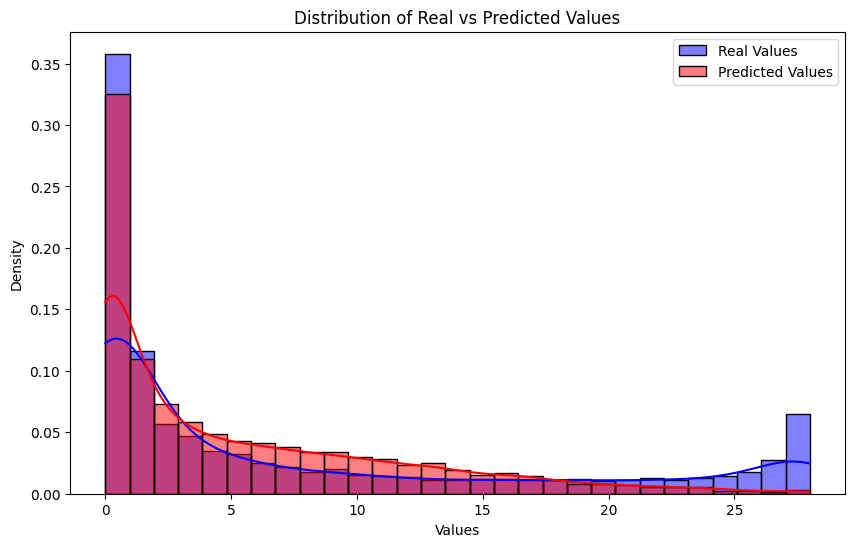

In [70]:
mae_scaled(y_val, final_ensemble_pred, prnt=True)

In [71]:
y_val = scale_back(y_val)
final_ensemble_pred = scale_back(final_ensemble_pred)
mistake = y_val - final_ensemble_pred

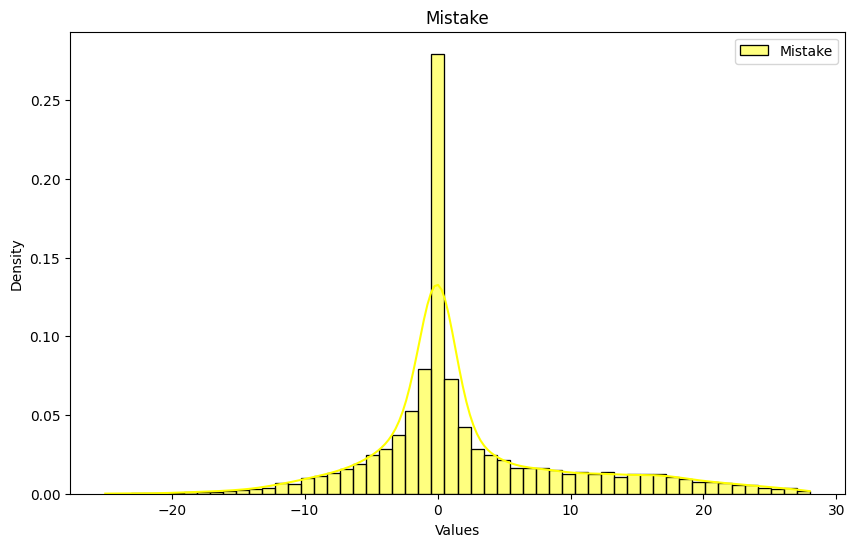

In [72]:
plt.figure(figsize=(10, 6))
sns.histplot(mistake, color='yellow', kde=True, label='Mistake', stat='density', bins=mistake.nunique())
plt.title("Mistake")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()

# Producing predictions

In [74]:
# train models
xgb_model.fit(X_encoded, y)
lgb_model.fit(X_encoded, y)
cat_model.fit(X_encoded, y)

umx_encoded = umx.copy()

umx_encoded = umx_encoded.drop(columns=['user_id'])

# only columns X_encoded remain in umx_encoded
umx_encoded = umx_encoded[[col for col in umx_encoded.columns if col in X_encoded.columns]]

# columns in X_encoded that are not in umx_encoded
missing_features = [col for col in X_encoded.columns if col not in umx_encoded.columns]
if missing_features:
    print(f"Missing features in umx_encoded: {missing_features}")

cat_features = umx_encoded.select_dtypes(include='object').columns
for col in cat_features:
    umx_encoded[col] = LabelEncoder().fit_transform(umx_encoded[col].astype(str))

In [75]:
# predict output
umx_xgb = xgb_model.predict(umx_encoded)
umx_lgb = lgb_model.predict(umx_encoded)
umx_cat = cat_model.predict(umx_encoded)

umx_ensemble_pred = w_xgb * umx_xgb + w_lgb * umx_lgb + w_cat * umx_cat
umx_pred_scal = scale_back(umx_ensemble_pred)

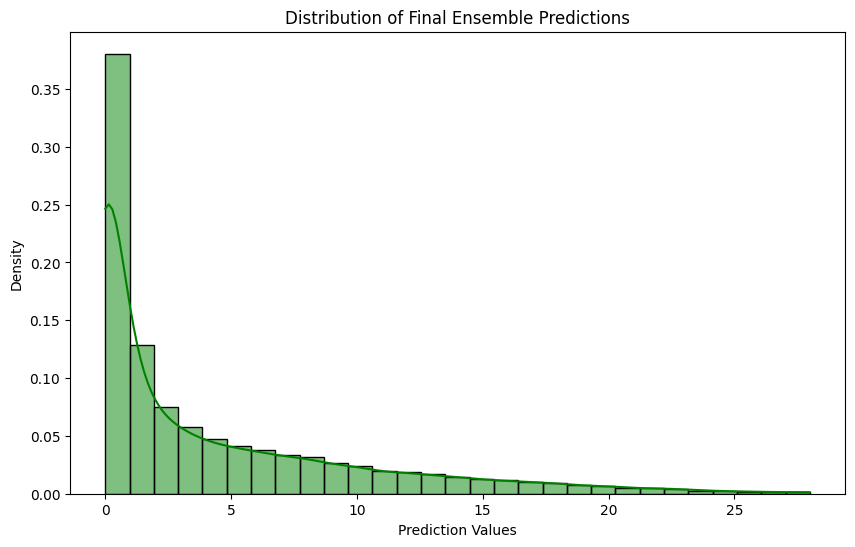

In [76]:
plt.figure(figsize=(10, 6))

sns.histplot(umx_pred_scal, color='green', kde=True, stat='density', bins=29)

plt.title("Distribution of Final Ensemble Predictions")
plt.xlabel("Prediction Values")
plt.ylabel("Density")
plt.show()

In [77]:
final_umx_output = pd.DataFrame(umx_pred_scal, columns=['prediction'])
final_umx_output.to_csv("days_active_first_28_days_after_registration_predictions.csv", index=False)

## Fruther improvements

Final Ensemble MAE: 5.0748


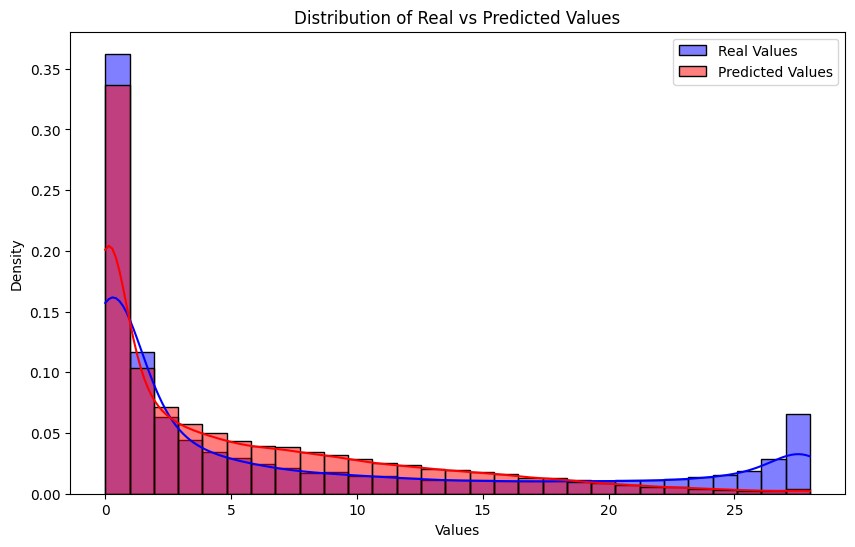

In [79]:
# predicts mistake
pred_xgb = xgb_model.predict(X_encoded)
pred_lgb = lgb_model.predict(X_encoded)
pred_cat = cat_model.predict(X_encoded)

ensemble_2 = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cat * pred_cat

mae_scaled(y, ensemble_2, prnt=True)

y_back = scale_back(y)
pred_back = scale_back(ensemble_2)

In [80]:
mistake = y_back - pred_back

In [81]:
print(skew(mistake))

0.9015453069793172


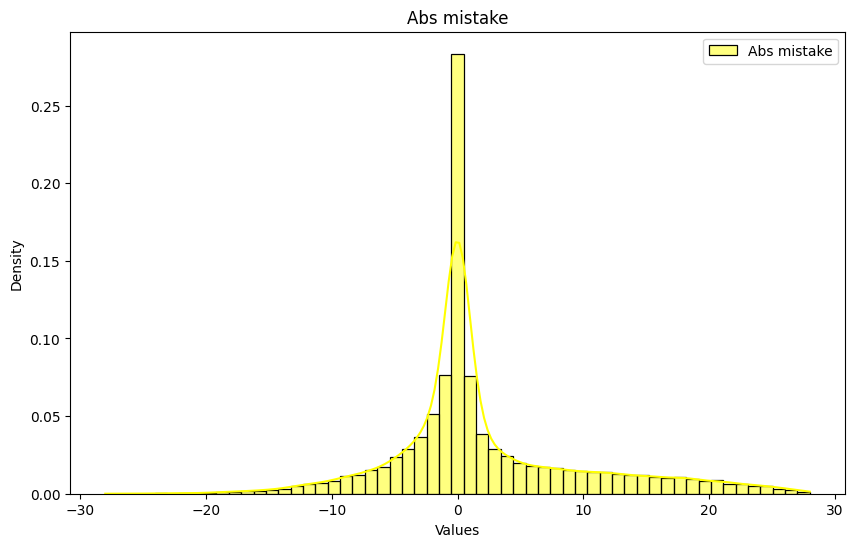

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(mistake, color='yellow', kde=True, label='Abs mistake', stat='density', bins=57)
plt.title("Abs mistake")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()

Objective: Classify data into mistake classes (I will use Regression, I used tearm classify to better discribe intention)

In [84]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_encoded, mistake, test_size=0.2, random_state=42)

In [85]:
def mae_calculator_2(model, trial=None):
    aes = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train_2.iloc[train_index], X_train_2.iloc[test_index]
        y_train_fold, y_test_fold = y_train_2.iloc[train_index], y_train_2.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        ae = mean_absolute_error(y_test_fold, y_pred)
        aes.append(ae)

    mae = np.mean(aes)

    if trial:
        print(f"Trial {trial.number} MAE: {mae:.4f}")
    else:
        print(f"MAE: {mae:.4f}")

    return mae

def objective_cat_2(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 4, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.5, 3.0)
    iterations = trial.suggest_int('iterations', 100, 200)

    cat_model_2 = cb.CatBoostRegressor(
        loss_function='MAE',
        learning_rate=learning_rate,
        depth=depth,
        subsample=subsample,
        colsample_bylevel=colsample_bylevel,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        random_seed=42,
        verbose=0
    )
    
    return mae_calculator_2(cat_model_2, trial)

In [86]:
study_cat_2 = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_cat_2.optimize(objective_cat_2, n_trials=50)
print("Best hyperparameters for CatBoost: ", study_cat_2.best_params)

[I 2025-04-30 01:30:35,167] A new study created in memory with name: no-name-2ba90dee-14a6-4629-be93-8cb21c8e4d51
[I 2025-04-30 01:31:41,158] Trial 0 finished with value: 5.163221338502358 and parameters: {'learning_rate': 0.11861663446573512, 'depth': 10, 'subsample': 0.8659969709057025, 'colsample_bylevel': 0.7993292420985183, 'l2_leaf_reg': 0.8900466011060912, 'iterations': 115}. Best is trial 0 with value: 5.163221338502358.


Trial 0 MAE: 5.1632


[I 2025-04-30 01:33:39,501] Trial 1 finished with value: 5.094477651413913 and parameters: {'learning_rate': 0.026844247528777843, 'depth': 10, 'subsample': 0.8005575058716043, 'colsample_bylevel': 0.8540362888980227, 'l2_leaf_reg': 0.5514612357395061, 'iterations': 197}. Best is trial 1 with value: 5.094477651413913.


Trial 1 MAE: 5.0945


[I 2025-04-30 01:33:50,298] Trial 2 finished with value: 5.089474266728392 and parameters: {'learning_rate': 0.2514083658321223, 'depth': 5, 'subsample': 0.5909124836035503, 'colsample_bylevel': 0.5917022549267169, 'l2_leaf_reg': 1.2606056073988443, 'iterations': 153}. Best is trial 2 with value: 5.089474266728392.


Trial 2 MAE: 5.0895


[I 2025-04-30 01:34:04,432] Trial 3 finished with value: 5.090186994928117 and parameters: {'learning_rate': 0.13526405540621358, 'depth': 6, 'subsample': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021, 'l2_leaf_reg': 1.2303616213380453, 'iterations': 137}. Best is trial 2 with value: 5.089474266728392.


Trial 3 MAE: 5.0902


[I 2025-04-30 01:34:36,556] Trial 4 finished with value: 5.143859230857399 and parameters: {'learning_rate': 0.1422602954229404, 'depth': 9, 'subsample': 0.5998368910791798, 'colsample_bylevel': 0.7571172192068059, 'l2_leaf_reg': 1.9810364221551062, 'iterations': 104}. Best is trial 2 with value: 5.089474266728392.


Trial 4 MAE: 5.1439


[I 2025-04-30 01:34:49,381] Trial 5 finished with value: 5.088566309999786 and parameters: {'learning_rate': 0.1861880070514171, 'depth': 5, 'subsample': 0.5325257964926398, 'colsample_bylevel': 0.9744427686266666, 'l2_leaf_reg': 2.9140800826863984, 'iterations': 181}. Best is trial 5 with value: 5.088566309999786.


Trial 5 MAE: 5.0886


[I 2025-04-30 01:34:59,242] Trial 6 finished with value: 5.076337919540384 and parameters: {'learning_rate': 0.09833799306027749, 'depth': 4, 'subsample': 0.8421165132560784, 'colsample_bylevel': 0.7200762468698007, 'l2_leaf_reg': 0.8050955871119471, 'iterations': 150}. Best is trial 6 with value: 5.076337919540384.


Trial 6 MAE: 5.0763


[I 2025-04-30 01:36:25,282] Trial 7 finished with value: 5.0866450467419835 and parameters: {'learning_rate': 0.019972671123413333, 'depth': 10, 'subsample': 0.6293899908000085, 'colsample_bylevel': 0.831261142176991, 'l2_leaf_reg': 1.2792776902235274, 'iterations': 152}. Best is trial 6 with value: 5.076337919540384.


Trial 7 MAE: 5.0866


[I 2025-04-30 01:36:40,731] Trial 8 finished with value: 5.083314669766178 and parameters: {'learning_rate': 0.1685459810095511, 'depth': 5, 'subsample': 0.9847923138822793, 'colsample_bylevel': 0.8875664116805573, 'l2_leaf_reg': 2.848747353910473, 'iterations': 190}. Best is trial 6 with value: 5.076337919540384.


Trial 8 MAE: 5.0833


[I 2025-04-30 01:37:35,988] Trial 9 finished with value: 5.26051770819587 and parameters: {'learning_rate': 0.18339099385521468, 'depth': 10, 'subsample': 0.5442462510259598, 'colsample_bylevel': 0.5979914312095727, 'l2_leaf_reg': 0.6130682222763452, 'iterations': 132}. Best is trial 6 with value: 5.076337919540384.


Trial 9 MAE: 5.2605


[I 2025-04-30 01:37:59,010] Trial 10 finished with value: 5.091428216457288 and parameters: {'learning_rate': 0.08131738166823185, 'depth': 7, 'subsample': 0.9515481201295128, 'colsample_bylevel': 0.673425445703311, 'l2_leaf_reg': 1.9998030768243473, 'iterations': 169}. Best is trial 6 with value: 5.076337919540384.


Trial 10 MAE: 5.0914


[I 2025-04-30 01:38:11,652] Trial 11 finished with value: 5.0799984342074 and parameters: {'learning_rate': 0.22306370637753414, 'depth': 4, 'subsample': 0.9743245943075546, 'colsample_bylevel': 0.9365224020178178, 'l2_leaf_reg': 2.980972147729747, 'iterations': 170}. Best is trial 6 with value: 5.076337919540384.


Trial 11 MAE: 5.0800


[I 2025-04-30 01:38:22,505] Trial 12 finished with value: 5.080650022668779 and parameters: {'learning_rate': 0.2810573693178722, 'depth': 4, 'subsample': 0.9009799030302936, 'colsample_bylevel': 0.6894387621623929, 'l2_leaf_reg': 2.3904835488383664, 'iterations': 168}. Best is trial 6 with value: 5.076337919540384.


Trial 12 MAE: 5.0807


[I 2025-04-30 01:38:32,464] Trial 13 finished with value: 5.079424939371268 and parameters: {'learning_rate': 0.22411583662091863, 'depth': 4, 'subsample': 0.6900889974935344, 'colsample_bylevel': 0.9929294675046495, 'l2_leaf_reg': 2.446008482921456, 'iterations': 168}. Best is trial 6 with value: 5.076337919540384.


Trial 13 MAE: 5.0794


[I 2025-04-30 01:38:50,035] Trial 14 finished with value: 5.089999204206824 and parameters: {'learning_rate': 0.08331067205387926, 'depth': 7, 'subsample': 0.6987936278139653, 'colsample_bylevel': 0.7063661045557401, 'l2_leaf_reg': 1.7081488697848437, 'iterations': 138}. Best is trial 6 with value: 5.076337919540384.


Trial 14 MAE: 5.0900


[I 2025-04-30 01:38:59,448] Trial 15 finished with value: 5.077905942028434 and parameters: {'learning_rate': 0.22196427766799065, 'depth': 4, 'subsample': 0.6850655980715776, 'colsample_bylevel': 0.773950191333736, 'l2_leaf_reg': 2.494987172697543, 'iterations': 157}. Best is trial 6 with value: 5.076337919540384.


Trial 15 MAE: 5.0779


[I 2025-04-30 01:39:11,431] Trial 16 finished with value: 5.082201935795238 and parameters: {'learning_rate': 0.07825799921137093, 'depth': 6, 'subsample': 0.7421879273099838, 'colsample_bylevel': 0.5150634695146866, 'l2_leaf_reg': 1.596523456239614, 'iterations': 124}. Best is trial 6 with value: 5.076337919540384.


Trial 16 MAE: 5.0822


[I 2025-04-30 01:39:40,158] Trial 17 finished with value: 5.237355860978865 and parameters: {'learning_rate': 0.28629804099472245, 'depth': 8, 'subsample': 0.8059244341834839, 'colsample_bylevel': 0.7423166184115674, 'l2_leaf_reg': 2.466569679424996, 'iterations': 148}. Best is trial 6 with value: 5.076337919540384.


Trial 17 MAE: 5.2374


[I 2025-04-30 01:39:54,791] Trial 18 finished with value: 5.089169022615882 and parameters: {'learning_rate': 0.11080578963504673, 'depth': 6, 'subsample': 0.6617037012714196, 'colsample_bylevel': 0.6473817814014824, 'l2_leaf_reg': 2.176362856512217, 'iterations': 158}. Best is trial 6 with value: 5.076337919540384.


Trial 18 MAE: 5.0892


[I 2025-04-30 01:40:04,040] Trial 19 finished with value: 5.08016084992847 and parameters: {'learning_rate': 0.21472225268550932, 'depth': 4, 'subsample': 0.7423578866620045, 'colsample_bylevel': 0.7708290067212532, 'l2_leaf_reg': 0.925922020496044, 'iterations': 142}. Best is trial 6 with value: 5.076337919540384.


Trial 19 MAE: 5.0802


[I 2025-04-30 01:40:15,986] Trial 20 finished with value: 5.076388350119719 and parameters: {'learning_rate': 0.05443274400481308, 'depth': 5, 'subsample': 0.8604484922881379, 'colsample_bylevel': 0.6374264744976313, 'l2_leaf_reg': 2.6690526341884113, 'iterations': 126}. Best is trial 6 with value: 5.076337919540384.


Trial 20 MAE: 5.0764


[I 2025-04-30 01:40:26,227] Trial 21 finished with value: 5.076413878696611 and parameters: {'learning_rate': 0.05408648648662848, 'depth': 5, 'subsample': 0.8707019854145864, 'colsample_bylevel': 0.6391686706406166, 'l2_leaf_reg': 2.665866247233266, 'iterations': 123}. Best is trial 6 with value: 5.076337919540384.


Trial 21 MAE: 5.0764


[I 2025-04-30 01:40:36,173] Trial 22 finished with value: 5.076784853270455 and parameters: {'learning_rate': 0.05396372133829436, 'depth': 5, 'subsample': 0.8878179731595285, 'colsample_bylevel': 0.6421816882586565, 'l2_leaf_reg': 2.662336400479703, 'iterations': 120}. Best is trial 6 with value: 5.076337919540384.


Trial 22 MAE: 5.0768


[I 2025-04-30 01:40:46,255] Trial 23 finished with value: 5.078574135328851 and parameters: {'learning_rate': 0.05095847844432639, 'depth': 6, 'subsample': 0.8508061898306275, 'colsample_bylevel': 0.5138448708784629, 'l2_leaf_reg': 2.7457456670472915, 'iterations': 106}. Best is trial 6 with value: 5.076337919540384.


Trial 23 MAE: 5.0786


[I 2025-04-30 01:40:57,089] Trial 24 finished with value: 5.076397114874758 and parameters: {'learning_rate': 0.050679022508606925, 'depth': 5, 'subsample': 0.9350716666156403, 'colsample_bylevel': 0.6444816056120761, 'l2_leaf_reg': 2.1094609576504544, 'iterations': 128}. Best is trial 6 with value: 5.076337919540384.


Trial 24 MAE: 5.0764


[I 2025-04-30 01:41:08,398] Trial 25 finished with value: 5.079321483209026 and parameters: {'learning_rate': 0.10617023550190112, 'depth': 5, 'subsample': 0.9210525917624132, 'colsample_bylevel': 0.7185796413817507, 'l2_leaf_reg': 2.1570316664318416, 'iterations': 132}. Best is trial 6 with value: 5.076337919540384.


Trial 25 MAE: 5.0793


[I 2025-04-30 01:41:22,856] Trial 26 finished with value: 5.079991736735088 and parameters: {'learning_rate': 0.04087834486482196, 'depth': 7, 'subsample': 0.8339644564074085, 'colsample_bylevel': 0.556575757223256, 'l2_leaf_reg': 1.5075165812405946, 'iterations': 109}. Best is trial 6 with value: 5.076337919540384.


Trial 26 MAE: 5.0800


[I 2025-04-30 01:41:47,024] Trial 27 finished with value: 5.093226847407275 and parameters: {'learning_rate': 0.08123822382373282, 'depth': 8, 'subsample': 0.9253085663206511, 'colsample_bylevel': 0.6153856269117716, 'l2_leaf_reg': 2.009034436350705, 'iterations': 127}. Best is trial 6 with value: 5.076337919540384.


Trial 27 MAE: 5.0932


[I 2025-04-30 01:41:58,826] Trial 28 finished with value: 5.083064866527144 and parameters: {'learning_rate': 0.09946692772980445, 'depth': 6, 'subsample': 0.778698462073285, 'colsample_bylevel': 0.6724064724505322, 'l2_leaf_reg': 2.243983247451729, 'iterations': 116}. Best is trial 6 with value: 5.076337919540384.


Trial 28 MAE: 5.0831


[I 2025-04-30 01:42:09,173] Trial 29 finished with value: 5.077955659786811 and parameters: {'learning_rate': 0.13056743260997716, 'depth': 4, 'subsample': 0.8441129683834311, 'colsample_bylevel': 0.8091131358276352, 'l2_leaf_reg': 0.8737298343651904, 'iterations': 141}. Best is trial 6 with value: 5.076337919540384.


Trial 29 MAE: 5.0780


[I 2025-04-30 01:42:19,739] Trial 30 finished with value: 5.075400568117585 and parameters: {'learning_rate': 0.015310537446248385, 'depth': 5, 'subsample': 0.9434085769780712, 'colsample_bylevel': 0.7072958782974688, 'l2_leaf_reg': 1.7577278038374111, 'iterations': 111}. Best is trial 30 with value: 5.075400568117585.


Trial 30 MAE: 5.0754


[I 2025-04-30 01:42:29,873] Trial 31 finished with value: 5.075196670696361 and parameters: {'learning_rate': 0.01139968333073722, 'depth': 5, 'subsample': 0.9445813967570695, 'colsample_bylevel': 0.7101057534780753, 'l2_leaf_reg': 1.8231721417554858, 'iterations': 113}. Best is trial 31 with value: 5.075196670696361.


Trial 31 MAE: 5.0752


[I 2025-04-30 01:42:37,744] Trial 32 finished with value: 5.07496852954948 and parameters: {'learning_rate': 0.012605956111289417, 'depth': 4, 'subsample': 0.9940045131925652, 'colsample_bylevel': 0.7124507395023151, 'l2_leaf_reg': 1.8225979687809004, 'iterations': 112}. Best is trial 32 with value: 5.07496852954948.


Trial 32 MAE: 5.0750


[I 2025-04-30 01:42:44,710] Trial 33 finished with value: 5.074909748944519 and parameters: {'learning_rate': 0.018098208953234787, 'depth': 4, 'subsample': 0.9993655518890346, 'colsample_bylevel': 0.7390310897251648, 'l2_leaf_reg': 1.8618456804669452, 'iterations': 100}. Best is trial 33 with value: 5.074909748944519.


Trial 33 MAE: 5.0749


[I 2025-04-30 01:42:52,764] Trial 34 finished with value: 5.0748583293050515 and parameters: {'learning_rate': 0.011228832825424015, 'depth': 4, 'subsample': 0.9925568756073098, 'colsample_bylevel': 0.8096221127124974, 'l2_leaf_reg': 1.846370984678076, 'iterations': 112}. Best is trial 34 with value: 5.0748583293050515.


Trial 34 MAE: 5.0749


[I 2025-04-30 01:42:59,943] Trial 35 finished with value: 5.07476985134975 and parameters: {'learning_rate': 0.010588915257309577, 'depth': 4, 'subsample': 0.9935220720506448, 'colsample_bylevel': 0.8000793047294962, 'l2_leaf_reg': 1.7901996889998326, 'iterations': 100}. Best is trial 35 with value: 5.07476985134975.


Trial 35 MAE: 5.0748


[I 2025-04-30 01:43:08,031] Trial 36 finished with value: 5.07548560590538 and parameters: {'learning_rate': 0.03260880210585364, 'depth': 4, 'subsample': 0.9968170894296671, 'colsample_bylevel': 0.8688020350217301, 'l2_leaf_reg': 1.5442643878914675, 'iterations': 100}. Best is trial 35 with value: 5.07476985134975.


Trial 36 MAE: 5.0755


[I 2025-04-30 01:43:15,562] Trial 37 finished with value: 5.074967558675737 and parameters: {'learning_rate': 0.02993926858428582, 'depth': 4, 'subsample': 0.9655839991886284, 'colsample_bylevel': 0.8019414711939116, 'l2_leaf_reg': 1.3033227743507587, 'iterations': 101}. Best is trial 35 with value: 5.07476985134975.


Trial 37 MAE: 5.0750


[I 2025-04-30 01:43:22,829] Trial 38 finished with value: 5.075250910175272 and parameters: {'learning_rate': 0.03495242334234464, 'depth': 4, 'subsample': 0.9636367167734342, 'colsample_bylevel': 0.8110042136417784, 'l2_leaf_reg': 1.135460986130213, 'iterations': 100}. Best is trial 35 with value: 5.07476985134975.


Trial 38 MAE: 5.0753


[I 2025-04-30 01:43:30,459] Trial 39 finished with value: 5.076058825270037 and parameters: {'learning_rate': 0.06594843288552554, 'depth': 4, 'subsample': 0.8997815455275464, 'colsample_bylevel': 0.9028287702065113, 'l2_leaf_reg': 1.3980492288448232, 'iterations': 106}. Best is trial 35 with value: 5.07476985134975.


Trial 39 MAE: 5.0761


[I 2025-04-30 01:44:11,585] Trial 40 finished with value: 5.08384593786054 and parameters: {'learning_rate': 0.030455149282517933, 'depth': 9, 'subsample': 0.9644751238412281, 'colsample_bylevel': 0.8310690365993191, 'l2_leaf_reg': 1.1396572716271278, 'iterations': 119}. Best is trial 35 with value: 5.07476985134975.


Trial 40 MAE: 5.0838


[I 2025-04-30 01:44:19,549] Trial 41 finished with value: 5.0747643109579155 and parameters: {'learning_rate': 0.010290826566978268, 'depth': 4, 'subsample': 0.9954917419052026, 'colsample_bylevel': 0.7462314917951588, 'l2_leaf_reg': 1.8560475536944527, 'iterations': 104}. Best is trial 41 with value: 5.0747643109579155.


Trial 41 MAE: 5.0748


[I 2025-04-30 01:44:26,923] Trial 42 finished with value: 5.074877210502767 and parameters: {'learning_rate': 0.02626852031009865, 'depth': 4, 'subsample': 0.9991417930830018, 'colsample_bylevel': 0.7810200893234792, 'l2_leaf_reg': 1.6648451469573753, 'iterations': 103}. Best is trial 41 with value: 5.0747643109579155.


Trial 42 MAE: 5.0749


[I 2025-04-30 01:44:34,898] Trial 43 finished with value: 5.074962380183403 and parameters: {'learning_rate': 0.019883102926016718, 'depth': 4, 'subsample': 0.9884358492650956, 'colsample_bylevel': 0.74756310296634, 'l2_leaf_reg': 1.915981818935816, 'iterations': 105}. Best is trial 41 with value: 5.0747643109579155.


Trial 43 MAE: 5.0750


[I 2025-04-30 01:44:42,328] Trial 44 finished with value: 5.074917462438165 and parameters: {'learning_rate': 0.039493391593688545, 'depth': 4, 'subsample': 0.9999533823185418, 'colsample_bylevel': 0.7797177274915615, 'l2_leaf_reg': 1.9314108876374116, 'iterations': 108}. Best is trial 41 with value: 5.0747643109579155.


Trial 44 MAE: 5.0749


[I 2025-04-30 01:44:52,430] Trial 45 finished with value: 5.076331231239825 and parameters: {'learning_rate': 0.06585224163630402, 'depth': 5, 'subsample': 0.9245767649862406, 'colsample_bylevel': 0.8425298917057048, 'l2_leaf_reg': 1.6548614012966627, 'iterations': 118}. Best is trial 41 with value: 5.0747643109579155.


Trial 45 MAE: 5.0763


[I 2025-04-30 01:45:09,088] Trial 46 finished with value: 5.076292784117148 and parameters: {'learning_rate': 0.02453776889847826, 'depth': 5, 'subsample': 0.9735784251228188, 'colsample_bylevel': 0.7346262041081472, 'l2_leaf_reg': 2.2942806106235003, 'iterations': 200}. Best is trial 41 with value: 5.0747643109579155.


Trial 46 MAE: 5.0763


[I 2025-04-30 01:45:16,418] Trial 47 finished with value: 5.075746383618769 and parameters: {'learning_rate': 0.06575284054508504, 'depth': 4, 'subsample': 0.9064708108873923, 'colsample_bylevel': 0.8682390639376094, 'l2_leaf_reg': 1.4902237416395911, 'iterations': 104}. Best is trial 41 with value: 5.0747643109579155.


Trial 47 MAE: 5.0757


[I 2025-04-30 01:45:24,443] Trial 48 finished with value: 5.074899020257517 and parameters: {'learning_rate': 0.01198433945133625, 'depth': 4, 'subsample': 0.9550381223629925, 'colsample_bylevel': 0.7833852895309387, 'l2_leaf_reg': 1.8314974482811712, 'iterations': 116}. Best is trial 41 with value: 5.0747643109579155.


Trial 48 MAE: 5.0749


[I 2025-04-30 01:45:32,584] Trial 49 finished with value: 5.07480205371936 and parameters: {'learning_rate': 0.011322374839476249, 'depth': 4, 'subsample': 0.9582664347831222, 'colsample_bylevel': 0.7863125826867071, 'l2_leaf_reg': 2.055845813693071, 'iterations': 114}. Best is trial 41 with value: 5.0747643109579155.


Trial 49 MAE: 5.0748
Best hyperparameters for CatBoost:  {'learning_rate': 0.010290826566978268, 'depth': 4, 'subsample': 0.9954917419052026, 'colsample_bylevel': 0.7462314917951588, 'l2_leaf_reg': 1.8560475536944527, 'iterations': 104}


I don't want to risk overfitting so I will use one of the tree based models for error prediction. After initial testing catboost showed the best results so I will be proceeding with that model.

In [88]:
cat_best_params_2 = study_cat_2.best_params

cat_model_2 = cb.CatBoostRegressor(
    loss_function='MAE',
    learning_rate=cat_best_params_2['learning_rate'],
    depth=cat_best_params_2['depth'],
    subsample=cat_best_params_2['subsample'],
    colsample_bylevel=cat_best_params_2['colsample_bylevel'],
    l2_leaf_reg=cat_best_params_2['l2_leaf_reg'],
    iterations=cat_best_params_2['iterations'],
    random_seed=42,
    verbose=0
)

cat_model_2.fit(X_train_2, y_train_2)
pred_cat_2 = cat_model.predict(X_val_2)

# MAE
mae_cat_2 = mean_absolute_error(y_val_2, pred_cat_2)

print(f"MAE: {mae_cat_2:.4f}")

MAE: 5.1812


In [89]:
cat_model_2.fit(X_encoded, mistake)
pred_mistake = cat_model_2.predict(X_encoded)

In [90]:
pred_mistake = pred_mistake.round()

In [91]:
# mistake if residual prediction is used
y_predict = pred_back - pred_mistake
mean_absolute_error(y_back, y_predict)

5.07476

MAE increased slightly so I will proceed without this adjustment